# Causal Flight Cancellation Prediction

**Project Goal**: Predict flight cancellations and attribute them to specific causes using causal inference.

**Timeline**: 4-6 weeks | **Focus**: Causation, not just correlation


In [ ]:
## Phase 1: Setup & Imports


In [4]:
# Standard libraries
import os
import warnings
warnings.filterwarnings('ignore')

# Data manipulation
import pandas as pd
import numpy as np

# Data collection
import requests
from bs4 import BeautifulSoup
import time
from datetime import datetime, timedelta

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

# Machine Learning
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
import xgboost as xgb
import lightgbm as lgb

# Deep Learning
import torch
import torch.nn as nn

# Causal Inference
import dowhy
from dowhy import CausalModel

# Attribution
import shap

# Utilities
from tqdm import tqdm
import pickle

# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

print("✅ All imports successful!")
print(f"📦 Pandas version: {pd.__version__}")
print(f"📦 PyTorch version: {torch.__version__}")
print(f"📦 DoWhy version: {dowhy.__version__}")


✅ All imports successful!
📦 Pandas version: 2.3.3
📦 PyTorch version: 2.9.1
📦 DoWhy version: 0.8


## Phase 2: Data Collection

**Goal**: Collect flight data (BTS), weather data (NOAA), and metadata


In [3]:
# ============================================================================
# DATA COLLECTION: Flight Cancellation Prediction
# ============================================================================
# Sources:
# 1. BTS (Bureau of Transportation Statistics) - Flight data
# 2. NOAA - Weather data
# 3. OpenFlights - Airport/Airline metadata
# ============================================================================

# Create data directories
os.makedirs("data/raw", exist_ok=True)
os.makedirs("data/processed", exist_ok=True)
os.makedirs("data/external", exist_ok=True)


print("📁 Data directories created")


📁 Data directories created


In [53]:
def load_bts_data_multiple(filepaths, output_path=None):
    """
    Load and merge multiple BTS flight data files.
    
    Args:
        filepaths: List of file paths or single file path
        output_path: Optional path to save merged CSV
    
    Returns:
        Combined DataFrame
    """
    # Convert single filepath to list
    if isinstance(filepaths, str):
        filepaths = [filepaths]
    
    # Key columns for cancellation analysis
    key_cols = [
        'FL_DATE', 'OP_CARRIER', 'OP_CARRIER_FL_NUM', 
        'ORIGIN', 'DEST', 'CANCELLED', 'CANCELLATION_CODE',
        'CRS_DEP_TIME', 'DEP_TIME', 'CRS_ARR_TIME', 'ARR_TIME',
        'DAY_OF_WEEK', 'MONTH',
        'WEATHER_DELAY', 'CARRIER_DELAY', 'NAS_DELAY', 
        'SECURITY_DELAY', 'LATE_AIRCRAFT_DELAY',
        'DISTANCE', 'DIVERTED'
    ]
    
    # Load and combine all files
    dfs = []
    for filepath in filepaths:
        df = pd.read_csv(filepath, low_memory=False)
        
        # Select available columns
        available_cols = [col for col in key_cols if col in df.columns]
        df = df[available_cols].copy()
        
        # Convert FL_DATE to datetime
        if 'FL_DATE' in df.columns:
            df['FL_DATE'] = pd.to_datetime(df['FL_DATE'])
        
        dfs.append(df)
        print(f"✅ Loaded {len(df):,} flights from {filepath.split('/')[-1]}")
    
    # Combine all dataframes
    combined_df = pd.concat(dfs, ignore_index=True)
    
    # Sort by date
    if 'FL_DATE' in combined_df.columns:
        combined_df = combined_df.sort_values('FL_DATE').reset_index(drop=True)
    
    # Save merged file if output path provided
    if output_path:
        combined_df.to_csv(output_path, index=False)
        print(f"\n💾 Saved merged data to: {output_path}")
    
    # Summary statistics
    print(f"\n{'='*60}")
    print(f"COMBINED DATA SUMMARY")
    print(f"{'='*60}")
    print(f"Total flights: {len(combined_df):,}")
    print(f"Date range: {combined_df['FL_DATE'].min()} to {combined_df['FL_DATE'].max()}")
    print(f"Total cancellations: {combined_df['CANCELLED'].sum():,} ({combined_df['CANCELLED'].mean()*100:.2f}%)")
    
    # Cancellation by month
    if 'MONTH' in combined_df.columns:
        print(f"\nCancellations by month:")
        month_cancel = combined_df.groupby('MONTH')['CANCELLED'].agg(['sum', 'mean', 'count'])
        month_cancel.columns = ['Cancellations', 'Cancel_Rate', 'Total_Flights']
        month_cancel['Cancel_Rate'] = month_cancel['Cancel_Rate'] * 100
        month_names = {1: 'January', 7: 'July', 9: 'September'}
        for month, row in month_cancel.iterrows():
            month_name = month_names.get(month, f'Month {month}')
            print(f"  {month_name}: {row['Cancellations']:,.0f} cancellations ({row['Cancel_Rate']:.2f}%)")
    
    # Cancellation reasons
    if 'CANCELLATION_CODE' in combined_df.columns:
        print(f"\nCancellation reasons (overall):")
        cancel_reasons = combined_df[combined_df['CANCELLED'] == 1]['CANCELLATION_CODE'].value_counts()
        reason_map = {'A': 'Carrier', 'B': 'Weather', 'C': 'NAS', 'D': 'Security'}
        for code, count in cancel_reasons.items():
            reason = reason_map.get(code, code)
            pct = count / combined_df['CANCELLED'].sum() * 100
            print(f"  {code} ({reason}): {count:,} ({pct:.1f}%)")
    
    print(f"{'='*60}\n")
    
    return combined_df

# Usage:
filepaths = [
    "/Users/ronny/Desktop/ML projects/Flight Cancels/data/raw/Jan_25.csv",  # Update with your actual filenames
    "/Users/ronny/Desktop/ML projects/Flight Cancels/data/raw/July_25.csv",
    "/Users/ronny/Desktop/ML projects/Flight Cancels/data/raw/SepT_2025.csv"
]

flights_df = load_bts_data_multiple(
    filepaths, 
    output_path="data/processed/flights_combined.csv"
)

✅ Loaded 539,747 flights from Jan_25.csv
✅ Loaded 631,428 flights from July_25.csv
✅ Loaded 562,439 flights from SepT_2025.csv

💾 Saved merged data to: data/processed/flights_combined.csv

COMBINED DATA SUMMARY
Total flights: 1,733,614
Date range: 2025-01-01 00:00:00 to 2025-09-30 00:00:00
Total cancellations: 34,671.0 (2.00%)

Cancellations by month:
  January: 16,312 cancellations (3.02%)
  July: 15,473 cancellations (2.45%)
  September: 2,886 cancellations (0.51%)

Cancellation reasons (overall):
  B (Weather): 25,216 (72.7%)
  A (Carrier): 5,379 (15.5%)
  C (NAS): 4,068 (11.7%)
  D (Security): 8 (0.0%)



In [82]:
# Get airport statistics (origin + destination combined)
origin_counts = flights_df['ORIGIN'].value_counts()
dest_counts = flights_df['DEST'].value_counts()

# Combine and sum (airports appear in both origin and dest)
airport_counts = pd.concat([origin_counts, dest_counts]).groupby(level=0).sum().sort_values(ascending=False)

print("=" * 60)
print("AIRPORT ANALYSIS")
print("=" * 60)
print(f"Total unique airports: {len(airport_counts)}")
print(f"Total flights: {airport_counts.sum():,}")

# Top 50 airports
top_50 = airport_counts.head(50)
print(f"\n📊 Top 50 Airports (by flight volume):")
print(f"   Total flights in top 50: {top_50.sum():,} ({top_50.sum()/airport_counts.sum()*100:.1f}% of all flights)")
print(f"\nTop 50 airports:")
for i, (airport, count) in enumerate(top_50.items(), 1):
    pct = count / airport_counts.sum() * 100
    print(f"   {i:2d}. {airport}: {count:,} flights ({pct:.2f}%)")

# Save top 50
top_50.to_csv("data/processed/top_50_airports.csv", header=['Flight_Count'])
print(f"\n💾 Saved top 50 to: data/processed/top_50_airports.csv")

# All airports (sorted by code)
all_airports = sorted(airport_counts.index.tolist())
print(f"\n📋 All airports ({len(all_airports)} total, sorted by code):")
print(all_airports)

# Save all airports
airport_counts.to_csv("data/processed/origin_airports.csv", header=['Flight_Count'])
print(f"💾 Saved all airports to: data/processed/origin_airports.csv")

# Coverage analysis
print(f"\n📈 Coverage Analysis:")
print(f"   Top 10 airports: {airport_counts.head(10).sum()/airport_counts.sum()*100:.1f}% of flights")
print(f"   Top 25 airports: {airport_counts.head(25).sum()/airport_counts.sum()*100:.1f}% of flights")
print(f"   Top 50 airports: {airport_counts.head(50).sum()/airport_counts.sum()*100:.1f}% of flights")
print(f"   Top 100 airports: {airport_counts.head(100).sum()/airport_counts.sum()*100:.1f}% of flights")

AIRPORT ANALYSIS
Total unique airports: 348
Total flights: 3,467,228

📊 Top 50 Airports (by flight volume):
   Total flights in top 50: 2,714,667 (78.3% of all flights)

Top 50 airports:
    1. ORD: 162,019 flights (4.67%)
    2. DEN: 161,432 flights (4.66%)
    3. DFW: 159,448 flights (4.60%)
    4. ATL: 156,550 flights (4.52%)
    5. CLT: 97,050 flights (2.80%)
    6. LAX: 95,035 flights (2.74%)
    7. PHX: 90,919 flights (2.62%)
    8. LAS: 90,272 flights (2.60%)
    9. SEA: 86,043 flights (2.48%)
   10. MCO: 75,773 flights (2.19%)
   11. DCA: 71,504 flights (2.06%)
   12. SFO: 71,248 flights (2.05%)
   13. BOS: 70,268 flights (2.03%)
   14. LGA: 67,978 flights (1.96%)
   15. EWR: 61,122 flights (1.76%)
   16. DTW: 61,023 flights (1.76%)
   17. IAH: 58,114 flights (1.68%)
   18. SLC: 58,021 flights (1.67%)
   19. MSP: 57,216 flights (1.65%)
   20. MIA: 53,657 flights (1.55%)
   21. JFK: 52,306 flights (1.51%)
   22. BNA: 51,091 flights (1.47%)
   23. BWI: 47,964 flights (1.38%)
   2

## Import and Merge NOAA data


In [83]:
def get_airport_coordinates_geocoding(airports_list):
    """
    Get airport coordinates using Nominatim (OpenStreetMap) - free, no API key.
    """
    import time
    
    coords = []
    failed = []
    
    print(f"🌍 Fetching coordinates for {len(airports_list)} airports...")
    
    for i, airport in enumerate(airports_list, 1):
        try:
            # Try airport code search
            url = "https://nominatim.openstreetmap.org/search"
            params = {
                'q': f"{airport} airport USA",
                'format': 'json',
                'limit': 1
            }
            headers = {'User-Agent': 'Flight-Cancellation-Project-1.0'}  # Required by Nominatim
            
            response = requests.get(url, params=params, headers=headers, timeout=10)
            data = response.json()
            
            if data and len(data) > 0:
                coords.append({
                    'airport_code': airport,
                    'lat': float(data[0]['lat']),
                    'lon': float(data[0]['lon']),
                    'airport_name': data[0].get('display_name', '')
                })
                if i % 10 == 0:  # Progress update every 10 (since only 50 total)
                    print(f"   Progress: {i}/{len(airports_list)} airports")
            else:
                failed.append(airport)
            
            time.sleep(1)  # Rate limiting: 1 request per second (free tier)
            
        except Exception as e:
            print(f"   Error for {airport}: {e}")
            failed.append(airport)
    
    df = pd.DataFrame(coords)
    print(f"\n✅ Found coordinates for {len(df)}/{len(airports_list)} airports")
    
    if failed:
        print(f"⚠️ Failed to find: {len(failed)} airports")
        print(f"   Failed airports: {failed}")
    
    return df

# Load top 50 airports from CSV
top_50_df = pd.read_csv("data/processed/top_50_airports.csv", index_col=0)
top_50_airports = top_50_df.index.tolist()  # Get airport codes (index)

print("=" * 60)
print("FETCHING COORDINATES FOR TOP 50 AIRPORTS")
print("=" * 60)
print(f"📊 Top 50 airports to fetch:")
print(f"   {', '.join(top_50_airports)}")
print(f"\n   Total flights in top 50: {top_50_df['Flight_Count'].sum():,}")
print(f"   Coverage: {top_50_df['Flight_Count'].sum() / (flights_df['ORIGIN'].value_counts().sum() + flights_df['DEST'].value_counts().sum()) * 100:.1f}% of all flights")

# Get coordinates (this will take ~50 seconds for 50 airports)
airport_coords_top50 = get_airport_coordinates_geocoding(top_50_airports)

# Save
airport_coords_top50.to_csv("data/processed/airport_coordinates_top50.csv", index=False)
print(f"\n💾 Saved to: data/processed/airport_coordinates_top50.csv")

# Display results
print(f"\n📋 Coordinates fetched:")
print(airport_coords_top50[['airport_code', 'lat', 'lon']].head(10))

FETCHING COORDINATES FOR TOP 50 AIRPORTS
📊 Top 50 airports to fetch:
   ORD, DEN, DFW, ATL, CLT, LAX, PHX, LAS, SEA, MCO, DCA, SFO, BOS, LGA, EWR, DTW, IAH, SLC, MSP, MIA, JFK, BNA, BWI, PHL, SAN, AUS, FLL, MDW, TPA, DAL, STL, PDX, HNL, SMF, IAD, HOU, RDU, MSY, MCI, SJC, IND, SNA, CMH, PIT, SAT, CLE, OAK, SJU, CVG, RSW

   Total flights in top 50: 2,714,667
   Coverage: 78.3% of all flights
🌍 Fetching coordinates for 50 airports...
   Progress: 10/50 airports
   Progress: 20/50 airports
   Progress: 30/50 airports
   Progress: 40/50 airports
   Progress: 50/50 airports

✅ Found coordinates for 50/50 airports

💾 Saved to: data/processed/airport_coordinates_top50.csv

📋 Coordinates fetched:
  airport_code        lat         lon
0          ORD  41.978252  -87.909235
1          DEN  39.860668 -104.685367
2          DFW  32.896519  -97.046522
3          ATL  33.637401  -84.429816
4          CLT  35.210741  -80.945744
5          LAX  33.942167 -118.421359
6          PHX  33.432849 -112.00679

In [ ]:
def fetch_weather_data_top50(flights_df, airport_coords_df, api_key, output_path=None):
    """
    Fetch weather data for top 50 airports only and merge with flights.
    
    Args:
        flights_df: DataFrame with flight data (must have ORIGIN, DEST, FL_DATE)
        airport_coords_df: DataFrame with top 50 airport coordinates (airport_code, lat, lon)
        api_key: Visual Crossing API key
        output_path: Optional path to save merged data
    
    Returns:
        Merged DataFrame with weather data
    """
    import time
    
    print("=" * 60)
    print("FETCHING WEATHER DATA (TOP 50 AIRPORTS ONLY)")
    print("=" * 60)
    
    # Get list of top 50 airports from coordinates
    top_50_airports = set(airport_coords_df['airport_code'].tolist())
    print(f"\n📊 Top 50 airports: {len(top_50_airports)} airports")
    
    # Filter flights to only include top 50 airports
    print("\n🔍 Filtering flights to top 50 airports...")
    flights_filtered = flights_df[
        flights_df['ORIGIN'].isin(top_50_airports) & 
        flights_df['DEST'].isin(top_50_airports)
    ].copy()
    
    original_count = len(flights_df)
    filtered_count = len(flights_filtered)
    coverage = filtered_count / original_count * 100
    
    print(f"   Original flights: {original_count:,}")
    print(f"   Filtered flights: {filtered_count:,} ({coverage:.1f}% of total)")
    
    if filtered_count == 0:
        print("❌ No flights found with top 50 airports!")
        return flights_df
    
    # Create airport coordinate lookup
    coord_lookup = airport_coords_df.set_index('airport_code')[['lat', 'lon']].to_dict('index')
    
    # Get unique airport-date combinations (for both origin and dest)
    print("\n📊 Analyzing flight data...")
    
    # Origin airports
    origin_dates = flights_filtered[['ORIGIN', 'FL_DATE']].drop_duplicates()
    origin_dates.columns = ['airport', 'date']
    
    # Destination airports
    dest_dates = flights_filtered[['DEST', 'FL_DATE']].drop_duplicates()
    dest_dates.columns = ['airport', 'date']
    
    # Combine and get unique combinations
    all_airport_dates = pd.concat([origin_dates, dest_dates]).drop_duplicates()
    all_airport_dates['date'] = pd.to_datetime(all_airport_dates['date']).dt.date
    
    print(f"   Unique airport-date combinations: {len(all_airport_dates):,}")
    print(f"   (Much faster than {len(flights_df[['ORIGIN', 'FL_DATE']].drop_duplicates()) + len(flights_df[['DEST', 'FL_DATE']].drop_duplicates()):,} for all airports!)")
    
    # Fetch weather data
    weather_data = []
    failed = []
    consecutive_429s = 0
    
    for idx, row in all_airport_dates.iterrows():
        airport = row['airport']
        date = row['date']
        
        # Get coordinates (should always exist since we filtered)
        if airport not in coord_lookup:
            failed.append((airport, date, "No coordinates"))
            continue
        
        lat = coord_lookup[airport]['lat']
        lon = coord_lookup[airport]['lon']
        
        retries = 0
        max_retries = 3
        
        while retries < max_retries:
            try:
                # Visual Crossing API call
                url = "https://weather.visualcrossing.com/VisualCrossingWebServices/rest/services/timeline"
                params = {
                    'location': f"{lat},{lon}",
                    'date': date.strftime('%Y-%m-%d'),
                    'key': api_key,
                    'include': 'days',
                    'elements': 'datetime,temp,precip,windspeed,visibility,snow,conditions'
                }
                
                response = requests.get(url, params=params, headers={'User-Agent': 'Flight-Cancellation-Project'}, timeout=30)
                
                if response.status_code == 200:
                    data = response.json()
                    
                    if 'days' in data and len(data['days']) > 0:
                        day_data = data['days'][0]
                        weather_data.append({
                            'airport': airport,
                            'date': date,
                            'temp_max': day_data.get('tempmax'),
                            'temp_min': day_data.get('tempmin'),
                            'temp_avg': day_data.get('temp'),
                            'precip': day_data.get('precip', 0),
                            'snow': day_data.get('snow', 0),
                            'windspeed': day_data.get('windspeed'),
                            'visibility': day_data.get('visibility'),
                            'conditions': day_data.get('conditions', '')
                        })
                        consecutive_429s = 0  # Reset on success
                    
                    break  # Success, exit retry loop
                
                elif response.status_code == 429:
                    consecutive_429s += 1
                    wait_time = min(60 * consecutive_429s, 300)  # Max 5 min wait
                    print(f"   ⚠️ Rate limit (429). Waiting {wait_time} seconds... (attempt {retries+1}/{max_retries})")
                    time.sleep(wait_time)
                    retries += 1
                    
                    if retries >= max_retries:
                        print(f"   ❌ Max retries reached for {airport} on {date}")
                        failed.append((airport, date, "Rate limit exceeded"))
                        break
                
                elif response.status_code == 401:
                    print("❌ API key invalid!")
                    return None
                
                else:
                    failed.append((airport, date, f"Status {response.status_code}"))
                    break
                    
            except Exception as e:
                if "429" in str(e):
                    consecutive_429s += 1
                    wait_time = min(60 * consecutive_429s, 300)
                    print(f"   ⚠️ Rate limit error. Waiting {wait_time} seconds...")
                    time.sleep(wait_time)
                    retries += 1
                else:
                    print(f"   ⚠️ Error for {airport} on {date}: {e}")
                    failed.append((airport, date, str(e)))
                    break
        
        # Progress update
        if len(weather_data) % 50 == 0:
            print(f"   Progress: {len(weather_data)}/{len(all_airport_dates)} fetched")
        
        # Rate limiting: 2 seconds between requests (more conservative)
        time.sleep(2)
    
    # Create weather DataFrame
    weather_df = pd.DataFrame(weather_data)
    
    if len(weather_df) > 0:
        weather_df['date'] = pd.to_datetime(weather_df['date'])
        print(f"\n✅ Fetched weather for {len(weather_df):,} airport-date combinations")
    else:
        print("\n❌ No weather data fetched!")
        return flights_filtered
    
    if failed:
        print(f"⚠️ Failed to fetch: {len(failed)} combinations")
        if len(failed) <= 10:
            print(f"   Failed: {failed}")
    
    # Merge with flight data (use filtered flights)
    print("\n🔗 Merging weather data with flights...")
    
    # Merge origin weather
    flights_merged = flights_filtered.merge(
        weather_df,
        left_on=['ORIGIN', 'FL_DATE'],
        right_on=['airport', 'date'],
        how='left',
        suffixes=('', '_origin')
    )
    
    # Rename origin weather columns
    origin_cols = ['temp_max', 'temp_min', 'temp_avg', 'precip', 'snow', 'windspeed', 'visibility', 'conditions']
    rename_dict = {col: f'{col}_origin' for col in origin_cols if col in flights_merged.columns}
    flights_merged = flights_merged.rename(columns=rename_dict)
    
    # Drop merge helper columns
    flights_merged = flights_merged.drop(columns=['airport', 'date'], errors='ignore')
    
    # Merge destination weather
    flights_merged = flights_merged.merge(
        weather_df,
        left_on=['DEST', 'FL_DATE'],
        right_on=['airport', 'date'],
        how='left',
        suffixes=('', '_dest')
    )
    
    # Rename destination weather columns
    rename_dict = {col: f'{col}_dest' for col in origin_cols if col in flights_merged.columns}
    flights_merged = flights_merged.rename(columns=rename_dict)
    
    # Drop merge helper columns
    flights_merged = flights_merged.drop(columns=['airport', 'date'], errors='ignore')
    
    # Summary
    print(f"\n✅ Merged weather data")
    print(f"   Total flights (filtered): {len(flights_merged):,}")
    print(f"   Flights with origin weather: {flights_merged['temp_avg_origin'].notna().sum():,} ({flights_merged['temp_avg_origin'].notna().mean()*100:.1f}%)")
    print(f"   Flights with dest weather: {flights_merged['temp_avg_dest'].notna().sum():,} ({flights_merged['temp_avg_dest'].notna().mean()*100:.1f}%)")
    
    # Save if output path provided
    if output_path:
        flights_merged.to_csv(output_path, index=False)
        print(f"\n💾 Saved merged data to: {output_path}")
    
    print("=" * 60)
    
    return flights_merged

# Usage:
# 1. Load your data
airport_coords_top50 = pd.read_csv("data/processed/airport_coordinates_top50.csv")
flights_df = pd.read_csv("data/processed/flights_combined.csv")
flights_df['FL_DATE'] = pd.to_datetime(flights_df['FL_DATE'])

# 2. Set your Visual Crossing API key
api_key = "G2SRNMYAF44NW4YYGMFXKK9UV"  # Replace with your actual key

# 3. Fetch and merge weather data (only for top 50 airports)
flights_with_weather = fetch_weather_data_top50(
    flights_df,
    airport_coords_top50,
    api_key,
    output_path="data/processed/flights_with_weather_top50.csv"
)

In [5]:
def fetch_weather_openmeteo_complete(flights_df, airport_coords_df, output_path=None):
    """
    Complete weather fetching using Open-Meteo (FREE, no API key).
    Includes progress bar and full merge logic.
    """
    import time
    from tqdm import tqdm
    
    print("=" * 60)
    print("FETCHING WEATHER FROM OPEN-METEO (FREE)")
    print("=" * 60)
    
    # Filter to top 50 airports
    top_50_airports = set(airport_coords_df['airport_code'].tolist())
    flights_filtered = flights_df[
        flights_df['ORIGIN'].isin(top_50_airports) & 
        flights_df['DEST'].isin(top_50_airports)
    ].copy()
    
    original_count = len(flights_df)
    filtered_count = len(flights_filtered)
    coverage = filtered_count / original_count * 100
    
    print(f"\n📊 Filtered to top 50 airports:")
    print(f"   Original flights: {original_count:,}")
    print(f"   Filtered flights: {filtered_count:,} ({coverage:.1f}% of total)")
    
    # Get unique combinations
    origin_dates = flights_filtered[['ORIGIN', 'FL_DATE']].drop_duplicates()
    dest_dates = flights_filtered[['DEST', 'FL_DATE']].drop_duplicates()
    all_airport_dates = pd.concat([
        origin_dates.rename(columns={'ORIGIN': 'airport', 'FL_DATE': 'date'}),
        dest_dates.rename(columns={'DEST': 'airport', 'FL_DATE': 'date'})
    ]).drop_duplicates()
    
    coord_lookup = airport_coords_df.set_index('airport_code')[['lat', 'lon']].to_dict('index')
    
    print(f"\n📊 Fetching weather for {len(all_airport_dates):,} airport-date combinations")
    print(f"   Estimated time: ~{len(all_airport_dates) * 0.5 / 60:.1f} minutes\n")
    
    weather_data = []
    failed = []
    
    # Progress bar
    with tqdm(total=len(all_airport_dates), desc="Fetching weather", unit="records") as pbar:
        for idx, row in all_airport_dates.iterrows():
            airport = row['airport']
            date = pd.to_datetime(row['date'])
            
            if airport not in coord_lookup:
                failed.append((airport, date, "No coordinates"))
                pbar.update(1)
                continue
            
            lat = coord_lookup[airport]['lat']
            lon = coord_lookup[airport]['lon']
            
            try:
                url = "https://archive-api.open-meteo.com/v1/archive"
                params = {
                    'latitude': lat,
                    'longitude': lon,
                    'start_date': date.strftime('%Y-%m-%d'),
                    'end_date': date.strftime('%Y-%m-%d'),
                    'daily': 'temperature_2m_max,temperature_2m_min,precipitation_sum,windspeed_10m_max,windgusts_10m_max',
                    'timezone': 'auto'
                }
                
                response = requests.get(url, params=params, timeout=30)
                
                if response.status_code == 200:
                    data = response.json()
                    if 'daily' in data and data['daily']:
                        daily = data['daily']
                        temp_max = daily.get('temperature_2m_max', [None])[0]
                        temp_min = daily.get('temperature_2m_min', [None])[0]
                        
                        weather_data.append({
                            'airport': airport,
                            'date': date.date(),
                            'temp_max': temp_max,
                            'temp_min': temp_min,
                            'temp_avg': (temp_max + temp_min) / 2 if temp_max and temp_min else None,
                            'precip': daily.get('precipitation_sum', [0])[0] or 0,
                            'windspeed': daily.get('windspeed_10m_max', [None])[0],
                            'windgust': daily.get('windgusts_10m_max', [None])[0],
                        })
                        pbar.set_postfix({'Success': len(weather_data), 'Failed': len(failed)})
                    else:
                        failed.append((airport, date, "No data"))
                else:
                    failed.append((airport, date, f"Status {response.status_code}"))
                
            except Exception as e:
                failed.append((airport, date, str(e)))
                pbar.set_postfix({'Errors': len(failed)})
            
            pbar.update(1)
            time.sleep(0.5)  # 2 requests/sec
    
    # Create weather DataFrame
    weather_df = pd.DataFrame(weather_data)
    
    if len(weather_df) > 0:
        weather_df['date'] = pd.to_datetime(weather_df['date'])
        print(f"\n✅ Fetched weather for {len(weather_df):,} airport-date combinations")
    else:
        print("\n❌ No weather data fetched!")
        return flights_filtered
    
    if failed:
        print(f"⚠️ Failed to fetch: {len(failed)} combinations")
    
    # Merge with flight data
    print("\n🔗 Merging weather data with flights...")
    
    # Merge origin weather
    flights_merged = flights_filtered.merge(
        weather_df,
        left_on=['ORIGIN', 'FL_DATE'],
        right_on=['airport', 'date'],
        how='left',
        suffixes=('', '_origin')
    )
    
    # Rename origin weather columns
    origin_cols = ['temp_max', 'temp_min', 'temp_avg', 'precip', 'windspeed', 'windgust']
    rename_dict = {col: f'{col}_origin' for col in origin_cols if col in flights_merged.columns}
    flights_merged = flights_merged.rename(columns=rename_dict)
    
    # Drop merge helper columns
    flights_merged = flights_merged.drop(columns=['airport', 'date'], errors='ignore')
    
    # Merge destination weather
    flights_merged = flights_merged.merge(
        weather_df,
        left_on=['DEST', 'FL_DATE'],
        right_on=['airport', 'date'],
        how='left',
        suffixes=('', '_dest')
    )
    
    # Rename destination weather columns
    rename_dict = {col: f'{col}_dest' for col in origin_cols if col in flights_merged.columns}
    flights_merged = flights_merged.rename(columns=rename_dict)
    
    # Drop merge helper columns
    flights_merged = flights_merged.drop(columns=['airport', 'date'], errors='ignore')
    
    # Summary
    print(f"\n✅ Merged weather data")
    print(f"   Total flights (filtered): {len(flights_merged):,}")
    print(f"   Flights with origin weather: {flights_merged['temp_avg_origin'].notna().sum():,} ({flights_merged['temp_avg_origin'].notna().mean()*100:.1f}%)")
    print(f"   Flights with dest weather: {flights_merged['temp_avg_dest'].notna().sum():,} ({flights_merged['temp_avg_dest'].notna().mean()*100:.1f}%)")
    
    # Save if output path provided
    if output_path:
        flights_merged.to_csv(output_path, index=False)
        print(f"\n💾 Saved merged data to: {output_path}")
    
    print("=" * 60)
    
    return flights_merged

# Usage (NO API KEY NEEDED!):
flights_with_weather = fetch_weather_openmeteo_complete(
    flights_df,
    airport_coords_top50,
    output_path="data/processed/flights_with_weather_openmeteo.csv"
)

FETCHING WEATHER FROM OPEN-METEO (FREE)

📊 Filtered to top 50 airports:
   Original flights: 1,733,614
   Filtered flights: 1,009,672 (58.2% of total)

📊 Fetching weather for 4,600 airport-date combinations
   Estimated time: ~38.3 minutes



Fetching weather: 100%|██████████| 4600/4600 [2:14:15<00:00,  1.75s/records, Success=4600, Failed=0]  



✅ Fetched weather for 4,600 airport-date combinations

🔗 Merging weather data with flights...

✅ Merged weather data
   Total flights (filtered): 1,009,672
   Flights with origin weather: 1,008,683 (99.9%)
   Flights with dest weather: 1,008,688 (99.9%)

💾 Saved merged data to: data/processed/flights_with_weather_openmeteo.csv


In [7]:
# Check weather data coverage
df = pd.read_csv("data/processed/flights_with_weather_openmeteo.csv")

print("Weather Data Coverage:")
print(f"  Origin weather: {df['temp_avg_origin'].notna().sum():,} / {len(df):,} ({df['temp_avg_origin'].notna().mean()*100:.1f}%)")
print(f"  Destination weather: {df['temp_avg_dest'].notna().sum():,} / {len(df):,} ({df['temp_avg_dest'].notna().mean()*100:.1f}%)")

print("\nWeather Statistics:")
print(f"  Avg origin temp: {df['temp_avg_origin'].mean():.1f}°C")
print(f"  Avg origin precip: {df['precip_origin'].mean():.2f}mm")
print(f"  Max wind speed: {df['windspeed_origin'].max():.1f}")

Weather Data Coverage:
  Origin weather: 1,008,683 / 1,009,672 (99.9%)
  Destination weather: 1,008,688 / 1,009,672 (99.9%)

Weather Statistics:
  Avg origin temp: 18.1°C
  Avg origin precip: 2.42mm
  Max wind speed: 39.2


## Phase 4: Data Preprocessing & Feature Engineering

**Goal**: Clean data, create features (time-based, weather, airport, airline, route)


In [66]:
#clean data

def clean_flight_data(df):
    """
    Clean and prepare flight data for modeling.
    
    Returns:
        Cleaned DataFrame ready for feature engineering
    """
    df = df.copy()
    
    print("=" * 60)
    print("DATA CLEANING")
    print("=" * 60)
    print(f"Starting with {len(df):,} flights")
    
    # 1. Convert date column
    if 'FL_DATE' in df.columns:
        df['FL_DATE'] = pd.to_datetime(df['FL_DATE'])
    
    # 2. Fill missing delay values with 0 (no delay = 0 minutes)
    delay_cols = ['WEATHER_DELAY', 'CARRIER_DELAY', 'NAS_DELAY', 
                  'SECURITY_DELAY', 'LATE_AIRCRAFT_DELAY']
    for col in delay_cols:
        if col in df.columns:
            df[col] = df[col].fillna(0)
    
    print(f"✅ Filled missing delay values")
    
    # 3. Fill missing weather data (use forward fill or mean)
    weather_cols = [col for col in df.columns if 'temp_' in col or 'precip' in col or 'windspeed' in col or 'windgust' in col]
    
    # Forward fill by airport-date (if same airport on same day)
    for col in weather_cols:
        if df[col].isna().sum() > 0:
            # Try forward fill first
            df[col] = df.groupby(['ORIGIN', 'FL_DATE'])[col].fillna(method='ffill')
            df[col] = df.groupby(['ORIGIN', 'FL_DATE'])[col].fillna(method='bfill')
            
            # If still missing, fill with airport mean
            if df[col].isna().sum() > 0:
                if 'origin' in col:
                    airport_col = 'ORIGIN'
                elif 'dest' in col:
                    airport_col = 'DEST'
                else:
                    airport_col = 'ORIGIN'
                
                airport_means = df.groupby(airport_col)[col].mean()
                df[col] = df.apply(
                    lambda row: airport_means.get(row[airport_col], df[col].mean()) 
                    if pd.isna(row[col]) else row[col], 
                    axis=1
                )
    
    print(f"✅ Filled missing weather data")
    
    # 4. Handle missing DEP_TIME and ARR_TIME (cancelled flights)
    # For cancelled flights, these are often missing - that's OK
    # We'll create a flag instead of dropping
    df['has_dep_time'] = df['DEP_TIME'].notna().astype(int)
    df['has_arr_time'] = df['ARR_TIME'].notna().astype(int)
    
    # Fill with scheduled times if missing
    if 'DEP_TIME' in df.columns:
        df['DEP_TIME'] = df['DEP_TIME'].fillna(df['CRS_DEP_TIME'])
    if 'ARR_TIME' in df.columns:
        df['ARR_TIME'] = df['ARR_TIME'].fillna(df['CRS_ARR_TIME'])
    
    print(f"✅ Handled missing time data")
    
    # 5. Remove invalid data
    # Remove flights with missing essential info
    initial_count = len(df)
    df = df.dropna(subset=['ORIGIN', 'DEST', 'OP_CARRIER', 'FL_DATE', 'CANCELLED'])
    
    # Remove flights with invalid distances
    if 'DISTANCE' in df.columns:
        df = df[df['DISTANCE'] > 0]
    
    removed = initial_count - len(df)
    if removed > 0:
        print(f"✅ Removed {removed:,} invalid records")
    
    # 6. Ensure CANCELLED is binary (0 or 1)
    df['CANCELLED'] = df['CANCELLED'].astype(int)
    
    # 7. Create cancellation reason flags (for analysis)
    if 'CANCELLATION_CODE' in df.columns:
        df['cancel_weather'] = (df['CANCELLATION_CODE'] == 'B').astype(int)
        df['cancel_carrier'] = (df['CANCELLATION_CODE'] == 'A').astype(int)
        df['cancel_nas'] = (df['CANCELLATION_CODE'] == 'C').astype(int)
        df['cancel_security'] = (df['CANCELLATION_CODE'] == 'D').astype(int)
    
    print(f"✅ Created cancellation reason flags")
    
    # 8. Summary
    print(f"\n✅ Cleaning complete!")
    print(f"   Final dataset: {len(df):,} flights")
    print(f"   Cancellation rate: {df['CANCELLED'].mean()*100:.2f}%")
    print(f"   Missing values: {df.isnull().sum().sum()} total")
    
    # Show columns with any missing values
    missing = df.isnull().sum()
    if missing.sum() > 0:
        print(f"\n   Columns with missing values:")
        for col, count in missing[missing > 0].items():
            print(f"      {col}: {count:,} ({count/len(df)*100:.2f}%)")
    
    print("=" * 60)
    
    return df

# Usage:
# Load data
df = pd.read_csv("data/processed/flights_with_weather_openmeteo.csv")
df['FL_DATE'] = pd.to_datetime(df['FL_DATE'])

# Clean data
df_clean = clean_flight_data(df)

# Save cleaned data
df_clean.to_csv("data/processed/flights_cleaned.csv", index=False)
print(f"\n💾 Saved cleaned data to: data/processed/flights_cleaned.csv")



DATA CLEANING
Starting with 1,009,672 flights
✅ Filled missing delay values
✅ Filled missing weather data
✅ Handled missing time data
✅ Created cancellation reason flags

✅ Cleaning complete!
   Final dataset: 1,009,672 flights
   Cancellation rate: 2.00%
   Missing values: 989448 total

   Columns with missing values:
      CANCELLATION_CODE: 989,448 (98.00%)

💾 Saved cleaned data to: data/processed/flights_cleaned.csv


In [67]:
#Feature Engineering

# ============================================================================
# FEATURE ENGINEERING - FLIGHT CANCELLATION PREDICTION
# ============================================================================

def create_time_features(df):
    """Create time-based features from FL_DATE and CRS_DEP_TIME."""
    df = df.copy()
    
    # Ensure FL_DATE is datetime
    if not pd.api.types.is_datetime64_any_dtype(df['FL_DATE']):
        df['FL_DATE'] = pd.to_datetime(df['FL_DATE'])
    
    # Date features
    df['year'] = df['FL_DATE'].dt.year
    df['month'] = df['FL_DATE'].dt.month
    df['day'] = df['FL_DATE'].dt.day
    df['day_of_week'] = df['FL_DATE'].dt.dayofweek  # 0=Monday, 6=Sunday
    df['day_of_year'] = df['FL_DATE'].dt.dayofyear
    df['week_of_year'] = df['FL_DATE'].dt.isocalendar().week
    
    # Season (Northern Hemisphere)
    df['season'] = df['month'].map({
        12: 0, 1: 0, 2: 0,   # Winter
        3: 1, 4: 1, 5: 1,     # Spring
        6: 2, 7: 2, 8: 2,     # Summer
        9: 3, 10: 3, 11: 3    # Fall
    })
    
    # Weekend flag
    df['is_weekend'] = (df['day_of_week'] >= 5).astype(int)
    
    # Holiday flags (major US holidays)
    holidays_2025 = [
        '2025-01-01',  # New Year
        '2025-01-20',  # MLK Day
        '2025-02-17',  # Presidents Day
        '2025-05-26',  # Memorial Day
        '2025-07-04',  # Independence Day
        '2025-09-01',  # Labor Day
        '2025-10-13',  # Columbus Day
        '2025-11-11',  # Veterans Day
        '2025-11-27',  # Thanksgiving
        '2025-12-25'   # Christmas
    ]
    df['is_holiday'] = df['FL_DATE'].dt.date.isin([pd.to_datetime(h).date() for h in holidays_2025]).astype(int)
    
    # Hour of day from CRS_DEP_TIME
    if 'CRS_DEP_TIME' in df.columns:
        # Convert time to hour (e.g., 1030 -> 10, 1430 -> 14)
        df['dep_hour'] = (df['CRS_DEP_TIME'] // 100).astype(int)
        df['dep_minute'] = (df['CRS_DEP_TIME'] % 100).astype(int)
        
        # Time of day categories
        df['dep_time_category'] = pd.cut(
            df['dep_hour'],
            bins=[0, 6, 12, 18, 24],
            labels=[0, 1, 2, 3],  # Night, Morning, Afternoon, Evening
            include_lowest=True
        ).astype(int)
    
    return df


def create_weather_features(df):
    """Create weather-related features."""
    df = df.copy()
    
    # Weather severity indicators
    # High precipitation threshold: >10mm
    if 'precip_origin' in df.columns:
        df['high_precip_origin'] = (df['precip_origin'] > 10).astype(int)
    if 'precip_dest' in df.columns:
        df['high_precip_dest'] = (df['precip_dest'] > 10).astype(int)
    
    # High wind threshold: >30 km/h
    if 'windspeed_origin' in df.columns:
        df['high_wind_origin'] = (df['windspeed_origin'] > 30).astype(int)
    if 'windspeed_dest' in df.columns:
        df['high_wind_dest'] = (df['windspeed_dest'] > 30).astype(int)
    
    # Extreme weather flag (high precip OR high wind)
    if 'high_precip_origin' in df.columns and 'high_wind_origin' in df.columns:
        df['extreme_weather_origin'] = ((df['high_precip_origin'] == 1) | (df['high_wind_origin'] == 1)).astype(int)
    if 'high_precip_dest' in df.columns and 'high_wind_dest' in df.columns:
        df['extreme_weather_dest'] = ((df['high_precip_dest'] == 1) | (df['high_wind_dest'] == 1)).astype(int)
    
    # Weather differences (origin - destination)
    if 'temp_avg_origin' in df.columns and 'temp_avg_dest' in df.columns:
        df['temp_diff'] = df['temp_avg_origin'] - df['temp_avg_dest']
    if 'precip_origin' in df.columns and 'precip_dest' in df.columns:
        df['precip_diff'] = df['precip_origin'] - df['precip_dest']
    if 'windspeed_origin' in df.columns and 'windspeed_dest' in df.columns:
        df['windspeed_diff'] = df['windspeed_origin'] - df['windspeed_dest']
    
    # Combined weather severity score
    weather_score = 0
    if 'precip_origin' in df.columns:
        weather_score += df['precip_origin'].fillna(0) / 10  # Normalize
    if 'windspeed_origin' in df.columns:
        weather_score += df['windspeed_origin'].fillna(0) / 30  # Normalize
    if 'precip_dest' in df.columns:
        weather_score += df['precip_dest'].fillna(0) / 10
    if 'windspeed_dest' in df.columns:
        weather_score += df['windspeed_dest'].fillna(0) / 30
    
    df['weather_severity_score'] = weather_score
    
    return df


def create_route_features(df):
    """Create route-related features."""
    df = df.copy()
    
    # Route identifier
    df['route'] = df['ORIGIN'].astype(str) + '_' + df['DEST'].astype(str)
    
    # Distance categories
    if 'DISTANCE' in df.columns:
        df['distance_category'] = pd.cut(
            df['DISTANCE'],
            bins=[0, 500, 1000, 2000, 10000],
            labels=[0, 1, 2, 3],  # Short, Medium, Long, Very Long
            include_lowest=True
        ).astype(int)
        
        # Estimated flight duration (hours) - rough estimate
        df['est_duration_hours'] = df['DISTANCE'] / 500  # ~500 mph average
    
    # Airport size categories (based on flight volume)
    # Calculate from training data only (to avoid leakage)
    # For now, we'll create a simple version
    if 'ORIGIN' in df.columns:
        origin_counts = df['ORIGIN'].value_counts()
        df['origin_airport_size'] = df['ORIGIN'].map(
            origin_counts.apply(lambda x: 0 if x < 10000 else (1 if x < 50000 else 2))
        ).fillna(0)  # Small=0, Medium=1, Large=2
    
    if 'DEST' in df.columns:
        dest_counts = df['DEST'].value_counts()
        df['dest_airport_size'] = df['DEST'].map(
            dest_counts.apply(lambda x: 0 if x < 10000 else (1 if x < 50000 else 2))
        ).fillna(0)
    
    return df


def create_airline_features(df):
    """Create airline-related features."""
    df = df.copy()
    
    # Airline code is already categorical, will be encoded later
    # For now, just ensure it's a string
    if 'OP_CARRIER' in df.columns:
        df['OP_CARRIER'] = df['OP_CARRIER'].astype(str)
    
    return df


def create_delay_features(df):
    """Create delay-related features from BTS delay data."""
    df = df.copy()
    
    # Total delay (sum of all delay types)
    delay_cols = ['WEATHER_DELAY', 'CARRIER_DELAY', 'NAS_DELAY', 
                  'SECURITY_DELAY', 'LATE_AIRCRAFT_DELAY']
    available_delays = [col for col in delay_cols if col in df.columns]
    
    if available_delays:
        df['total_delay'] = df[available_delays].sum(axis=1)
        
        # Delay flags
        df['has_weather_delay'] = (df['WEATHER_DELAY'].fillna(0) > 0).astype(int) if 'WEATHER_DELAY' in df.columns else 0
        df['has_carrier_delay'] = (df['CARRIER_DELAY'].fillna(0) > 0).astype(int) if 'CARRIER_DELAY' in df.columns else 0
        df['has_nas_delay'] = (df['NAS_DELAY'].fillna(0) > 0).astype(int) if 'NAS_DELAY' in df.columns else 0
    
    return df


def create_all_features(df):
    """Apply all feature engineering functions."""
    print("=" * 60)
    print("FEATURE ENGINEERING")
    print("=" * 60)
    print(f"Starting with {len(df):,} flights")
    print(f"Initial columns: {len(df.columns)}")
    
    # Apply all feature engineering
    df = create_time_features(df)
    print("✅ Created time features")
    
    df = create_weather_features(df)
    print("✅ Created weather features")
    
    df = create_route_features(df)
    print("✅ Created route features")
    
    df = create_airline_features(df)
    print("✅ Created airline features")
    
    df = create_delay_features(df)
    print("✅ Created delay features")
    
    print(f"\n✅ Feature engineering complete!")
    print(f"   Final columns: {len(df.columns)}")
    print(f"   New features: {len(df.columns) - 20}")  # Approximate
    print("=" * 60)
    
    return df


# ============================================================================
# USAGE
# ============================================================================

# Load cleaned data
df = pd.read_csv("data/processed/flights_cleaned.csv")
df['FL_DATE'] = pd.to_datetime(df['FL_DATE'])

# Apply feature engineering
df_features = create_all_features(df)

# Save features
df_features.to_csv("data/processed/flights_with_features.csv", index=False)
print(f"\n💾 Saved to: data/processed/flights_with_features.csv")

# Show feature summary
print("\n📊 Feature Summary:")
print(f"   Total features: {len(df_features.columns)}")
print(f"   Categorical: {df_features.select_dtypes(include=['object']).columns.tolist()}")
print(f"   Numerical: {len(df_features.select_dtypes(include=[np.number]).columns)}")


FEATURE ENGINEERING
Starting with 1,009,672 flights
Initial columns: 38
✅ Created time features
✅ Created weather features
✅ Created route features
✅ Created airline features
✅ Created delay features

✅ Feature engineering complete!
   Final columns: 69
   New features: 49

💾 Saved to: data/processed/flights_with_features.csv

📊 Feature Summary:
   Total features: 69
   Categorical: ['OP_CARRIER', 'ORIGIN', 'DEST', 'CANCELLATION_CODE', 'route']
   Numerical: 63


In [68]:
# ============================================================================
# LEAKAGE CHECK #1: STATIC CHECKS (BEFORE SPLIT)
# ============================================================================
# WHEN TO RUN: After feature engineering, BEFORE train/test split
# PURPOSE: Identify and remove features with obvious leakage issues
# ============================================================================

def check_static_leakage(df, target_col='CANCELLED'):
    """
    Check for static data leakage issues before train/test split.
    
    Args:
        df: DataFrame with features and target
        target_col: Name of target column
    
    Returns:
        DataFrame with leakage features removed
    """
    print("=" * 60)
    print("LEAKAGE CHECK #1: STATIC CHECKS (BEFORE SPLIT)")
    print("=" * 60)
    print(f"Checking {len(df):,} records with {len(df.columns)} features")
    
    leakage_features = []
    warnings = []
    
    # Check 1: Features that directly contain target information
    print("\n1. Checking for direct target leakage...")
    direct_leakage = ['CANCELLATION_CODE', 'cancel_weather', 'cancel_carrier', 
                      'cancel_nas', 'cancel_security']
    for col in direct_leakage:
        if col in df.columns:
            leakage_features.append(col)
            print(f"   ❌ {col}: Contains target information (removing)")
    
    # Check 2: Features that only exist after cancellation
    print("\n2. Checking for post-cancellation features...")
    if 'ARR_TIME' in df.columns:
        # ARR_TIME might be missing for cancelled flights - that's OK
        # But if we use it as a feature, it could leak
        cancelled_missing_arr = df[df[target_col] == 1]['ARR_TIME'].isna().sum()
        total_cancelled = df[target_col].sum()
        if cancelled_missing_arr == total_cancelled:
            warnings.append("ARR_TIME: All cancelled flights have missing ARR_TIME (OK)")
        else:
            warnings.append("ARR_TIME: Some cancelled flights have ARR_TIME (check if used as feature)")
    
    # Check 3: Features with perfect correlation (preliminary check)
    print("\n3. Checking for perfect correlations...")
    numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    if target_col in numeric_cols:
        numeric_cols.remove(target_col)
    
    for col in numeric_cols:
        if df[col].nunique() > 1:  # Skip constant features
            corr = abs(df[col].corr(df[target_col]))
            if corr > 0.99:
                leakage_features.append(col)
                print(f"   ❌ {col}: Perfect correlation ({corr:.4f}) with target (removing)")
    
    # Check 4: Features that are duplicates of target
    print("\n4. Checking for target duplicates...")
    for col in df.columns:
        if col != target_col:
            if df[col].equals(df[target_col]):
                leakage_features.append(col)
                print(f"   ❌ {col}: Identical to target (removing)")
    
    # Check 5: Features with suspiciously high correlation
    print("\n5. Checking for suspicious correlations (>0.95)...")
    for col in numeric_cols:
        if col not in leakage_features and df[col].nunique() > 1:
            corr = abs(df[col].corr(df[target_col]))
            if corr > 0.95:
                warnings.append(f"{col}: Very high correlation ({corr:.4f}) with target - investigate")
    
    # Remove leakage features
    if leakage_features:
        df_clean = df.drop(columns=leakage_features)
        print(f"\n✅ Removed {len(leakage_features)} leakage features: {leakage_features}")
    else:
        df_clean = df.copy()
        print("\n✅ No obvious leakage features found")
    
    # Print warnings
    if warnings:
        print(f"\n⚠️ Warnings ({len(warnings)}):")
        for warning in warnings:
            print(f"   - {warning}")
    
    print(f"\n✅ Static check complete")
    print(f"   Features before: {len(df.columns)}")
    print(f"   Features after: {len(df_clean.columns)}")
    print("=" * 60)
    
    return df_clean

# Usage (run after feature engineering, before split):
df_clean = check_static_leakage(df_features, target_col='CANCELLED')

LEAKAGE CHECK #1: STATIC CHECKS (BEFORE SPLIT)
Checking 1,009,672 records with 69 features

1. Checking for direct target leakage...
   ❌ CANCELLATION_CODE: Contains target information (removing)
   ❌ cancel_weather: Contains target information (removing)
   ❌ cancel_carrier: Contains target information (removing)
   ❌ cancel_nas: Contains target information (removing)
   ❌ cancel_security: Contains target information (removing)

2. Checking for post-cancellation features...

3. Checking for perfect correlations...
   ❌ has_arr_time: Perfect correlation (0.9928) with target (removing)

4. Checking for target duplicates...

5. Checking for suspicious correlations (>0.95)...

✅ Removed 6 leakage features: ['CANCELLATION_CODE', 'cancel_weather', 'cancel_carrier', 'cancel_nas', 'cancel_security', 'has_arr_time']

⚠️ Warnings (2):
   - ARR_TIME: Some cancelled flights have ARR_TIME (check if used as feature)
   - has_dep_time: Very high correlation (0.9758) with target - investigate

✅ Stat

In [69]:
# ============================================================================
# TRAIN/VALIDATION/TEST SPLIT
# ============================================================================
# WHEN TO RUN: After static leakage check, before encoding
# PURPOSE: Split data into training, validation, and testing sets
# ============================================================================

from sklearn.model_selection import train_test_split

# Separate features and target
X = df_clean.drop('CANCELLED', axis=1)
y = df_clean['CANCELLED']

print("=" * 60)
print("TRAIN/VALIDATION/TEST SPLIT")
print("=" * 60)
print(f"Total records: {len(X):,}")
print(f"Features: {len(X.columns)}")
print(f"Target distribution:")
print(f"   Cancelled: {y.sum():,} ({y.mean()*100:.2f}%)")
print(f"   Not Cancelled: {(y==0).sum():,} ({(y==0).mean()*100:.2f}%)")

# First split: 80% train+val, 20% test
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y,
    test_size=0.2,           # 20% for test
    random_state=42,
    stratify=y
)

# Second split: 75% train, 25% val (of the 80%, so 60% train, 20% val overall)
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp,
    test_size=0.25,          # 25% of 80% = 20% of total
    random_state=42,
    stratify=y_temp
)

print(f"\n✅ Split complete:")
print(f"   Training set:   {len(X_train):,} records ({len(X_train)/len(X)*100:.1f}%)")
print(f"   Validation set: {len(X_val):,} records ({len(X_val)/len(X)*100:.1f}%)")
print(f"   Test set:       {len(X_test):,} records ({len(X_test)/len(X)*100:.1f}%)")

print(f"\n   Training cancellation rate:   {y_train.mean()*100:.2f}%")
print(f"   Validation cancellation rate: {y_val.mean()*100:.2f}%")
print(f"   Test cancellation rate:       {y_test.mean()*100:.2f}%")

print(f"\n   Features in each set: {len(X_train.columns)}")
print("=" * 60)

TRAIN/VALIDATION/TEST SPLIT
Total records: 1,009,672
Features: 62
Target distribution:
   Cancelled: 20,224 (2.00%)
   Not Cancelled: 989,448 (98.00%)

✅ Split complete:
   Training set:   605,802 records (60.0%)
   Validation set: 201,935 records (20.0%)
   Test set:       201,935 records (20.0%)

   Training cancellation rate:   2.00%
   Validation cancellation rate: 2.00%
   Test cancellation rate:       2.00%

   Features in each set: 62


In [72]:
# ============================================================================
# LEAKAGE CHECK #2: DYNAMIC CHECKS (AFTER SPLIT) - UPDATED
# ============================================================================
# WHEN TO RUN: After train/val/test split, BEFORE encoding/scaling
# PURPOSE: Check for leakage in feature relationships and computation
# ============================================================================

def check_dynamic_leakage(X_train, y_train, X_val, y_val, X_test, y_test):
    """
    Check for dynamic data leakage issues after train/val/test split.
    
    Args:
        X_train: Training features
        y_train: Training target
        X_val: Validation features
        y_val: Validation target
        X_test: Test features
        y_test: Test target
    
    Returns:
        List of issues and warnings found
    """
    print("=" * 60)
    print("LEAKAGE CHECK #2: DYNAMIC CHECKS (AFTER SPLIT)")
    print("=" * 60)
    print(f"Training set:   {len(X_train):,} records")
    print(f"Validation set: {len(X_val):,} records")
    print(f"Test set:       {len(X_test):,} records")
    
    issues = []
    warnings = []
    
    # Check 1: Perfect correlation in training set
    print("\n1. Checking for perfect correlations in training set...")
    numeric_cols = X_train.select_dtypes(include=[np.number]).columns.tolist()
    
    for col in numeric_cols:
        if X_train[col].nunique() > 1:
            corr = abs(X_train[col].corr(y_train))
            if corr > 0.99:
                issues.append(f"{col}: Perfect correlation ({corr:.4f}) with target in training")
                print(f"   ❌ {col}: Perfect correlation ({corr:.4f})")
            elif corr > 0.95:
                warnings.append(f"{col}: Very high correlation ({corr:.4f}) with target")
                print(f"   ⚠️ {col}: Very high correlation ({corr:.4f})")
    
    # Check 2: Features that perfectly separate classes
    print("\n2. Checking for features that perfectly separate classes...")
    for col in numeric_cols:
        if X_train[col].nunique() > 10:
            try:
                bins = pd.cut(X_train[col], bins=min(10, X_train[col].nunique()), duplicates='drop')
                cancel_by_bin = X_train.groupby(bins)[y_train.name].agg(['mean', 'count'])
                
                if cancel_by_bin['mean'].max() == 1.0 and cancel_by_bin['mean'].min() == 0.0:
                    if cancel_by_bin['count'].min() > 5:
                        issues.append(f"{col}: Perfectly separates cancelled/non-cancelled classes")
                        print(f"   ❌ {col}: Perfectly separates classes")
            except:
                pass
    
    # Check 3: Check for data leakage in feature computation
    print("\n3. Checking for test/val data in feature computation...")
    print("   (Manual check required - verify your feature engineering code)")
    print("   ✅ Ensure historical averages computed from training only")
    print("   ✅ Ensure encoders/scalers fit only on training")
    
    # Check 4: Compare train vs val vs test distributions
    print("\n4. Comparing train vs val vs test feature distributions...")
    for col in numeric_cols[:10]:
        train_mean = X_train[col].mean()
        val_mean = X_val[col].mean()
        test_mean = X_test[col].mean()
        
        val_diff = abs((train_mean - val_mean) / train_mean * 100) if train_mean != 0 else 0
        test_diff = abs((train_mean - test_mean) / train_mean * 100) if train_mean != 0 else 0
        
        if val_diff > 50:
            warnings.append(f"{col}: Large train/val distribution difference ({val_diff:.1f}%)")
            print(f"   ⚠️ {col}: Train={train_mean:.2f}, Val={val_mean:.2f} ({val_diff:.1f}% diff)")
        
        if test_diff > 50:
            warnings.append(f"{col}: Large train/test distribution difference ({test_diff:.1f}%)")
            print(f"   ⚠️ {col}: Train={train_mean:.2f}, Test={test_mean:.2f} ({test_diff:.1f}% diff)")
    
    # Check 5: Check for constant features
    print("\n5. Checking for constant features...")
    constant_features = []
    for col in X_train.columns:
        if X_train[col].nunique() <= 1:
            constant_features.append(col)
    
    if constant_features:
        warnings.append(f"Constant features found: {constant_features}")
        print(f"   ⚠️ Found {len(constant_features)} constant features: {constant_features}")
        print(f"   💡 Remove these features before modeling")
    
    # Summary
    print(f"\n✅ Dynamic check complete")
    if issues:
        print(f"   ❌ Issues found: {len(issues)}")
        for issue in issues:
            print(f"      - {issue}")
    else:
        print(f"   ✅ No major issues found")
    
    if warnings:
        print(f"   ⚠️ Warnings: {len(warnings)}")
        for warning in warnings[:5]:
            print(f"      - {warning}")
    
    print("=" * 60)
    
    return issues, warnings, constant_features

# Usage (run after split, before encoding):
issues, warnings, constant_features = check_dynamic_leakage(
    X_train, y_train, X_val, y_val, X_test, y_test
)

# Remove constant features
if constant_features:
    print(f"\n🔧 Removing constant features: {constant_features}")
    X_train = X_train.drop(columns=constant_features)
    X_val = X_val.drop(columns=constant_features)
    X_test = X_test.drop(columns=constant_features)
    print(f"✅ Removed. Remaining features: {len(X_train.columns)}")

LEAKAGE CHECK #2: DYNAMIC CHECKS (AFTER SPLIT)
Training set:   605,802 records
Validation set: 201,935 records
Test set:       201,935 records

1. Checking for perfect correlations in training set...
   ⚠️ has_dep_time: Very high correlation (0.9756)

2. Checking for features that perfectly separate classes...

3. Checking for test/val data in feature computation...
   (Manual check required - verify your feature engineering code)
   ✅ Ensure historical averages computed from training only
   ✅ Ensure encoders/scalers fit only on training

4. Comparing train vs val vs test feature distributions...

5. Checking for constant features...
   ⚠️ Found 1 constant features: ['year']
   💡 Remove these features before modeling

✅ Dynamic check complete
   ✅ No major issues found
   ⚠️ Warnings: 2
      - has_dep_time: Very high correlation (0.9756) with target
      - Constant features found: ['year']

🔧 Removing constant features: ['year']
✅ Removed. Remaining features: 61


In [74]:
# ============================================================================
# REMOVE DEP_TIME FROM ALL SETS
# ============================================================================
# WHEN TO RUN: After dynamic leakage check, before encoding
# PURPOSE: Remove redundant feature from train, val, and test
# ============================================================================

print("=" * 60)
print("REMOVING DEP_TIME FROM ALL SETS")
print("=" * 60)

if 'DEP_TIME' in X_train.columns:
    print(f"Features before: {len(X_train.columns)}")
    
    # Remove from ALL sets
    X_train = X_train.drop(columns=['DEP_TIME'])
    X_val = X_val.drop(columns=['DEP_TIME'])
    X_test = X_test.drop(columns=['DEP_TIME'])
    
    print(f"✅ Removed DEP_TIME from train, val, and test")
    print(f"Features after: {len(X_train.columns)}")
    print(f"\n   Train features: {len(X_train.columns)}")
    print(f"   Val features:   {len(X_val.columns)}")
    print(f"   Test features:  {len(X_test.columns)}")
    
    # Verify all sets have same features
    if (set(X_train.columns) == set(X_val.columns) == set(X_test.columns)):
        print(f"\n✅ All sets have identical features")
    else:
        print(f"\n❌ ERROR: Feature mismatch between sets!")
else:
    print("DEP_TIME not found in features")

print("=" * 60)

REMOVING DEP_TIME FROM ALL SETS
DEP_TIME not found in features


In [78]:
# ============================================================================
# FEATURE LISTING
# ============================================================================
# WHEN TO RUN: After feature engineering and cleaning, before encoding
# PURPOSE: List and categorize all features for review
# ============================================================================

def list_all_features(X_train, X_val=None, X_test=None):
    """
    List and categorize all features in the dataset.
    
    Args:
        X_train: Training features
        X_val: Validation features (optional)
        X_test: Test features (optional)
    """
    print("=" * 60)
    print("FEATURE LISTING")
    print("=" * 60)
    print(f"Total features: {len(X_train.columns)}")
    
    # Verify all sets have same features
    if X_val is not None and X_test is not None:
        if set(X_train.columns) == set(X_val.columns) == set(X_test.columns):
            print("✅ All sets have identical features")
        else:
            print("❌ WARNING: Feature mismatch between sets!")
    
    # Categorize features
    print("\n" + "=" * 60)
    print("FEATURE CATEGORIES")
    print("=" * 60)
    
    # Time features
    time_features = [col for col in X_train.columns if any(x in col.lower() for x in 
                   ['date', 'time', 'day', 'week', 'month', 'year', 'hour', 'season', 'holiday', 'weekend'])]
    
    # Weather features
    weather_features = [col for col in X_train.columns if any(x in col.lower() for x in 
                       ['temp', 'precip', 'wind', 'weather', 'snow', 'visibility', 'severity'])]
    
    # Route features
    route_features = [col for col in X_train.columns if any(x in col.lower() for x in 
                    ['origin', 'dest', 'route', 'distance', 'duration', 'airport'])]
    
    # Airline features
    airline_features = [col for col in X_train.columns if any(x in col.lower() for x in 
                      ['carrier', 'airline', 'op_carrier'])]
    
    # Delay features
    delay_features = [col for col in X_train.columns if any(x in col.lower() for x in 
                    ['delay', 'has_'])]
    
    # Other features
    other_features = [col for col in X_train.columns if col not in 
                     time_features + weather_features + route_features + 
                     airline_features + delay_features]
    
    # Print by category
    categories = [
        ("Time Features", time_features),
        ("Weather Features", weather_features),
        ("Route Features", route_features),
        ("Airline Features", airline_features),
        ("Delay Features", delay_features),
        ("Other Features", other_features)
    ]
    
    for category_name, features in categories:
        if features:
            print(f"\n{category_name} ({len(features)}):")
            for i, feat in enumerate(sorted(features), 1):
                dtype = X_train[feat].dtype
                nunique = X_train[feat].nunique()
                print(f"   {i:2d}. {feat:30s} | Type: {str(dtype):10s} | Unique: {nunique:,}")
    
    # Data types summary
    print("\n" + "=" * 60)
    print("DATA TYPE SUMMARY")
    print("=" * 60)
    
    dtype_counts = X_train.dtypes.value_counts()
    for dtype, count in dtype_counts.items():
        print(f"   {str(dtype):20s}: {count:3d} features")
    
    # Categorical vs Numerical
    print("\n" + "=" * 60)
    print("FEATURE TYPE BREAKDOWN")
    print("=" * 60)
    
    categorical = X_train.select_dtypes(include=['object', 'category']).columns.tolist()
    numerical = X_train.select_dtypes(include=[np.number]).columns.tolist()
    
    print(f"   Categorical features: {len(categorical)}")
    if categorical:
        print(f"      {', '.join(categorical[:10])}")
        if len(categorical) > 10:
            print(f"      ... and {len(categorical) - 10} more")
    
    print(f"\n   Numerical features: {len(numerical)}")
    if numerical:
        print(f"      {', '.join(numerical[:10])}")
        if len(numerical) > 10:
            print(f"      ... and {len(numerical) - 10} more")
    
    # Complete feature list
    print("\n" + "=" * 60)
    print("COMPLETE FEATURE LIST")
    print("=" * 60)
    for i, col in enumerate(sorted(X_train.columns), 1):
        dtype = X_train[feat].dtype if 'feat' in locals() else X_train[col].dtype
        nunique = X_train[col].nunique()
        missing = X_train[col].isna().sum()
        missing_pct = missing / len(X_train) * 100
        
        print(f"{i:3d}. {col:35s} | {str(dtype):10s} | Unique: {nunique:6,} | Missing: {missing:6,} ({missing_pct:5.2f}%)")
    
    print("=" * 60)
    
    return {
        'time_features': time_features,
        'weather_features': weather_features,
        'route_features': route_features,
        'airline_features': airline_features,
        'delay_features': delay_features,
        'other_features': other_features,
        'categorical': categorical,
        'numerical': numerical
    }

# Usage:
feature_categories = list_all_features(X_train, X_val, X_test)

FEATURE LISTING
Total features: 59
✅ All sets have identical features

FEATURE CATEGORIES

Time Features (17):
    1. CRS_ARR_TIME                   | Type: int64      | Unique: 1,315
    2. CRS_DEP_TIME                   | Type: int64      | Unique: 1,228
    3. DAY_OF_WEEK                    | Type: int64      | Unique: 7
    4. FL_DATE                        | Type: datetime64[ns] | Unique: 92
    5. MONTH                          | Type: int64      | Unique: 3
    6. day                            | Type: int32      | Unique: 31
    7. day_of_week                    | Type: int32      | Unique: 7
    8. day_of_year                    | Type: int32      | Unique: 92
    9. dep_hour                       | Type: int64      | Unique: 24
   10. dep_time_category              | Type: int64      | Unique: 4
   11. est_duration_hours             | Type: float64    | Unique: 835
   12. has_dep_time                   | Type: int64      | Unique: 2
   13. is_holiday                     | Typ

In [77]:
# ============================================================================
# CHECK AND REMOVE ARR_TIME
# ============================================================================

print("=" * 60)
print("ARR_TIME Analysis")
print("=" * 60)

if 'ARR_TIME' in X_train.columns:
    # Check ARR_TIME for cancelled flights
    cancelled_indices = y_train[y_train == 1].index
    cancelled_arr_time = X_train.loc[cancelled_indices, 'ARR_TIME']
    
    print(f"ARR_TIME statistics:")
    print(f"   Total records: {len(X_train):,}")
    print(f"   Cancelled flights: {y_train.sum():,}")
    print(f"   ARR_TIME missing for cancelled: {cancelled_arr_time.isna().sum():,}")
    print(f"   ARR_TIME not missing for cancelled: {cancelled_arr_time.notna().sum():,}")
    
    # Check if ARR_TIME equals CRS_ARR_TIME for cancelled flights
    if 'CRS_ARR_TIME' in X_train.columns:
        cancelled_with_arr = X_train.loc[cancelled_indices].dropna(subset=['ARR_TIME'])
        if len(cancelled_with_arr) > 0:
            same_as_scheduled = (cancelled_with_arr['ARR_TIME'] == cancelled_with_arr['CRS_ARR_TIME']).sum()
            print(f"   Cancelled flights where ARR_TIME = CRS_ARR_TIME: {same_as_scheduled:,}")
    
    print(f"\n💡 Recommendation:")
    print(f"   - Remove ARR_TIME (similar to DEP_TIME)")
    print(f"   - Keep CRS_ARR_TIME (scheduled time - always available)")
    print(f"   - ARR_TIME is not available at prediction time for cancelled flights")
    
    # Remove ARR_TIME
    print(f"\n🔧 Removing ARR_TIME from all sets...")
    X_train = X_train.drop(columns=['ARR_TIME'])
    X_val = X_val.drop(columns=['ARR_TIME'])
    X_test = X_test.drop(columns=['ARR_TIME'])
    print(f"✅ Removed. Remaining features: {len(X_train.columns)}")
else:
    print("ARR_TIME not found in features")

print("=" * 60)

ARR_TIME Analysis
ARR_TIME statistics:
   Total records: 605,802
   Cancelled flights: 12,134
   ARR_TIME missing for cancelled: 0
   ARR_TIME not missing for cancelled: 12,134
   Cancelled flights where ARR_TIME = CRS_ARR_TIME: 12,134

💡 Recommendation:
   - Remove ARR_TIME (similar to DEP_TIME)
   - Keep CRS_ARR_TIME (scheduled time - always available)
   - ARR_TIME is not available at prediction time for cancelled flights

🔧 Removing ARR_TIME from all sets...
✅ Removed. Remaining features: 59


### Encoding Data

In [81]:
# ============================================================================
# ENCODING CATEGORICAL FEATURES
# ============================================================================
# WHEN TO RUN: After feature cleaning, before scaling
# PURPOSE: Convert categorical features to numerical
# ============================================================================
!pip install category_encoders
from category_encoders import TargetEncoder
import pandas as pd
import numpy as np

print("=" * 60)
print("ENCODING CATEGORICAL FEATURES")
print("=" * 60)

# Identify categorical features
categorical_cols = ['OP_CARRIER', 'ORIGIN', 'DEST', 'route']

print(f"Categorical features to encode: {categorical_cols}")
print(f"   OP_CARRIER: {X_train['OP_CARRIER'].nunique()} unique values")
print(f"   ORIGIN: {X_train['ORIGIN'].nunique()} unique values")
print(f"   DEST: {X_train['DEST'].nunique()} unique values")
print(f"   route: {X_train['route'].nunique()} unique values")

# Target encoding (fit on training only!)
print("\n🔧 Applying Target Encoding...")
encoder = TargetEncoder()

# Fit on training data only (prevents leakage!)
encoder.fit(X_train[categorical_cols], y_train)

# Transform all sets
X_train_encoded = encoder.transform(X_train[categorical_cols])
X_val_encoded = encoder.transform(X_val[categorical_cols])
X_test_encoded = encoder.transform(X_test[categorical_cols])

# Rename encoded columns
X_train_encoded.columns = [f'{col}_encoded' for col in categorical_cols]
X_val_encoded.columns = [f'{col}_encoded' for col in categorical_cols]
X_test_encoded.columns = [f'{col}_encoded' for col in categorical_cols]

print("✅ Encoding complete")

# Combine encoded features with numerical features
print("\n🔗 Combining encoded and numerical features...")

# Get numerical features (exclude categoricals and datetime)
numerical_cols = [col for col in X_train.columns 
                  if col not in categorical_cols and col != 'FL_DATE']

X_train_final = pd.concat([
    X_train[numerical_cols],
    X_train_encoded
], axis=1)

X_val_final = pd.concat([
    X_val[numerical_cols],
    X_val_encoded
], axis=1)

X_test_final = pd.concat([
    X_test[numerical_cols],
    X_test_encoded
], axis=1)

print(f"✅ Combined features")
print(f"   Training set: {len(X_train_final):,} records, {len(X_train_final.columns)} features")
print(f"   Validation set: {len(X_val_final):,} records, {len(X_val_final.columns)} features")
print(f"   Test set: {len(X_test_final):,} records, {len(X_test_final.columns)} features")

print("\n📊 Feature summary:")
print(f"   Numerical features: {len(numerical_cols)}")
print(f"   Encoded categoricals: {len(categorical_cols)}")
print(f"   Total features: {len(X_train_final.columns)}")

print("=" * 60)

ENCODING CATEGORICAL FEATURES
Categorical features to encode: ['OP_CARRIER', 'ORIGIN', 'DEST', 'route']
   OP_CARRIER: 14 unique values
   ORIGIN: 50 unique values
   DEST: 50 unique values
   route: 1967 unique values

🔧 Applying Target Encoding...
✅ Encoding complete

🔗 Combining encoded and numerical features...
✅ Combined features
   Training set: 605,802 records, 58 features
   Validation set: 201,935 records, 58 features
   Test set: 201,935 records, 58 features

📊 Feature summary:
   Numerical features: 54
   Encoded categoricals: 4
   Total features: 58


In [82]:
# ============================================================================
# SCALING FEATURES
# ============================================================================
# WHEN TO RUN: After encoding, before model training
# PURPOSE: Scale features to similar ranges for better model performance
# ============================================================================

from sklearn.preprocessing import StandardScaler

print("=" * 60)
print("SCALING FEATURES")
print("=" * 60)

# Initialize scaler
scaler = StandardScaler()

# Fit on training data only (prevents leakage!)
print("🔧 Fitting scaler on training data...")
scaler.fit(X_train_final)

# Transform all sets
print("🔧 Scaling all sets...")
X_train_scaled = scaler.transform(X_train_final)
X_val_scaled = scaler.transform(X_val_final)
X_test_scaled = scaler.transform(X_test_final)

# Convert back to DataFrame (optional, but helpful)
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train_final.columns, index=X_train_final.index)
X_val_scaled = pd.DataFrame(X_val_scaled, columns=X_val_final.columns, index=X_val_final.index)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test_final.columns, index=X_test_final.index)

print("✅ Scaling complete")
print(f"   Training set: {X_train_scaled.shape}")
print(f"   Validation set: {X_val_scaled.shape}")
print(f"   Test set: {X_test_scaled.shape}")

print("\n📊 Scaled feature statistics (training set):")
print(f"   Mean: {X_train_scaled.mean().mean():.6f} (should be ~0)")
print(f"   Std: {X_train_scaled.std().mean():.6f} (should be ~1)")

print("=" * 60)

SCALING FEATURES
🔧 Fitting scaler on training data...
🔧 Scaling all sets...
✅ Scaling complete
   Training set: (605802, 58)
   Validation set: (201935, 58)
   Test set: (201935, 58)

📊 Scaled feature statistics (training set):
   Mean: 0.000000 (should be ~0)
   Std: 1.000001 (should be ~1)


### Model Training: 

In [90]:
# ============================================================================
# REMOVE has_dep_time (PREDICTION-TIME LEAKAGE)
# ============================================================================
# WHEN TO RUN: Before final model training
# PURPOSE: Remove features not available at prediction time
# ============================================================================

print("=" * 60)
print("REMOVING PREDICTION-TIME LEAKAGE")
print("=" * 60)

# Features to remove (not available at prediction time)
prediction_time_leakage = ['has_dep_time']

print(f"Removing features not available at prediction time:")
print(f"   {prediction_time_leakage}")

# Remove from all sets
X_train_final = X_train_final.drop(columns=prediction_time_leakage, errors='ignore')
X_val_final = X_val_final.drop(columns=prediction_time_leakage, errors='ignore')
X_test_final = X_test_final.drop(columns=prediction_time_leakage, errors='ignore')

print(f"\n✅ Removed. Remaining features: {len(X_train_final.columns)}")

# Re-scale (since we removed a feature)
print("\n🔧 Re-scaling features...")
scaler = StandardScaler()
scaler.fit(X_train_final)

X_train_scaled = pd.DataFrame(
    scaler.transform(X_train_final), 
    columns=X_train_final.columns, 
    index=X_train_final.index
)
X_val_scaled = pd.DataFrame(
    scaler.transform(X_val_final), 
    columns=X_val_final.columns, 
    index=X_val_final.index
)
X_test_scaled = pd.DataFrame(
    scaler.transform(X_test_final), 
    columns=X_test_final.columns, 
    index=X_test_final.index
)

print("✅ Re-scaling complete")
print("=" * 60)

# Retrain model without has_dep_time
print("\n" + "=" * 60)
print("RETRAINING MODEL (WITHOUT has_dep_time)")
print("=" * 60)

xgb_model_v2 = xgb.XGBClassifier(
    objective='binary:logistic',
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    scale_pos_weight=49,
    random_state=42,
    eval_metric='logloss'
)

xgb_model_v2.fit(
    X_train_scaled, y_train,
    eval_set=[(X_train_scaled, y_train), (X_val_scaled, y_val)],
    verbose=False
)

# Evaluate
xgb_test_pred_v2 = xgb_model_v2.predict(X_test_scaled)
xgb_test_proba_v2 = xgb_model_v2.predict_proba(X_test_scaled)[:, 1]

print("\n📊 Model Performance (Without has_dep_time):")
print(f"   Test Accuracy:  {accuracy_score(y_test, xgb_test_pred_v2):.4f}")
print(f"   Test Precision: {precision_score(y_test, xgb_test_pred_v2):.4f}")
print(f"   Test Recall:    {recall_score(y_test, xgb_test_pred_v2):.4f}")
print(f"   Test F1-Score:  {f1_score(y_test, xgb_test_pred_v2):.4f}")
print(f"   Test ROC-AUC:   {roc_auc_score(y_test, xgb_test_proba_v2):.4f}")

print("\n📊 Comparison:")
print(f"   With has_dep_time:    Accuracy = 0.9968, F1 = 0.9244")
print(f"   Without has_dep_time: Accuracy = {accuracy_score(y_test, xgb_test_pred_v2):.4f}, F1 = {f1_score(y_test, xgb_test_pred_v2):.4f}")

print("\n✅ Model retrained with prediction-time features only")
print("=" * 60)

REMOVING PREDICTION-TIME LEAKAGE
Removing features not available at prediction time:
   ['has_dep_time']

✅ Removed. Remaining features: 57

🔧 Re-scaling features...
✅ Re-scaling complete

RETRAINING MODEL (WITHOUT has_dep_time)

📊 Model Performance (Without has_dep_time):
   Test Accuracy:  0.8954
   Test Precision: 0.1448
   Test Recall:    0.8598
   Test F1-Score:  0.2478
   Test ROC-AUC:   0.9449

📊 Comparison:
   With has_dep_time:    Accuracy = 0.9968, F1 = 0.9244
   Without has_dep_time: Accuracy = 0.8954, F1 = 0.2478

✅ Model retrained with prediction-time features only


In [96]:
# ============================================================================
# REMOVE PREDICTION-TIME LEAKAGE (48-HOUR ADVANCE PREDICTION)
# ============================================================================
# WHEN TO RUN: Before final model training
# PURPOSE: Remove features not available 48 hours before flight
# ============================================================================

print("=" * 60)
print("REMOVING PREDICTION-TIME LEAKAGE (48-HOUR ADVANCE)")
print("=" * 60)

# Features NOT available 48 hours before flight
prediction_time_leakage = [
    # Current flight delays (not known until flight happens)
    'total_delay',
    'WEATHER_DELAY',
    'CARRIER_DELAY',
    'NAS_DELAY',
    'SECURITY_DELAY',
    'LATE_AIRCRAFT_DELAY',
    'has_weather_delay',
    'has_carrier_delay',
    'has_nas_delay',
    
    # Actual times (not known until flight happens)
    'has_dep_time',
    'ARR_TIME',
    'DEP_TIME',
    
    # Post-flight information
    'DIVERTED'
]

print(f"Removing features not available 48 hours before flight:")
for feat in prediction_time_leakage:
    if feat in X_train_final.columns:
        print(f"   ❌ {feat}")

# Remove from all sets
features_to_remove = [f for f in prediction_time_leakage if f in X_train_final.columns]

X_train_final = X_train_final.drop(columns=features_to_remove, errors='ignore')
X_val_final = X_val_final.drop(columns=features_to_remove, errors='ignore')
X_test_final = X_test_final.drop(columns=features_to_remove, errors='ignore')

print(f"\n✅ Removed {len(features_to_remove)} features")
print(f"   Remaining features: {len(X_train_final.columns)}")

# ============================================================================
# CREATE HISTORICAL DELAY FEATURES (Available 48 hours before)
# ============================================================================
# These use past flight data, not current flight data
# ============================================================================

print("\n" + "=" * 60)
print("CREATING HISTORICAL DELAY FEATURES")
print("=" * 60)

# We need to go back to original data to compute historical patterns
# Load original data with delays
df_original = pd.read_csv("data/processed/flights_cleaned.csv")
df_original['FL_DATE'] = pd.to_datetime(df_original['FL_DATE'])

# Merge with train/val/test indices to compute historical features
# This is complex - we'll create a simpler approach

# For now, create historical features using training data statistics
# (In production, you'd compute these from historical database)

print("💡 Historical delay features would be computed from:")
print("   - Average delays for route in past 7 days")
print("   - Average delays for airline in past 30 days")
print("   - Average delays for origin airport in past 7 days")
print("   - Historical cancellation rates by route/airline")

print("\n⚠️ Note: For this project, we'll proceed without historical delays")
print("   (They would require time-series feature engineering)")

# Re-scale after removing features
print("\n🔧 Re-scaling features...")
scaler = StandardScaler()
scaler.fit(X_train_final)

X_train_scaled = pd.DataFrame(
    scaler.transform(X_train_final), 
    columns=X_train_final.columns, 
    index=X_train_final.index
)
X_val_scaled = pd.DataFrame(
    scaler.transform(X_val_final), 
    columns=X_val_final.columns, 
    index=X_val_final.index
)
X_test_scaled = pd.DataFrame(
    scaler.transform(X_test_final), 
    columns=X_test_final.columns, 
    index=X_test_final.index
)

print("✅ Re-scaling complete")
print(f"   Final feature count: {len(X_train_final.columns)}")

print("\n📊 Features available for 48-hour advance prediction:")
print(f"   ✅ Weather features (from forecasts)")
print(f"   ✅ Scheduled flight info (CRS_DEP_TIME, route, airline)")
print(f"   ✅ Time features (day, month, season)")
print(f"   ✅ Historical patterns (encoded routes/airlines)")
print(f"   ❌ Current delays (removed - not available)")

print("=" * 60)

# ============================================================================
# RETRAIN MODEL (WITH PREDICTION-TIME FEATURES ONLY)
# ============================================================================

print("\n" + "=" * 60)
print("RETRAINING MODEL (48-HOUR ADVANCE PREDICTION)")
print("=" * 60)

xgb_model_final = xgb.XGBClassifier(
    objective='binary:logistic',
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    scale_pos_weight=49,
    random_state=42,
    eval_metric='logloss'
)

xgb_model_final.fit(
    X_train_scaled, y_train,
    eval_set=[(X_train_scaled, y_train), (X_val_scaled, y_val)],
    verbose=False
)

# Evaluate
xgb_test_pred_final = xgb_model_final.predict(X_test_scaled)
xgb_test_proba_final = xgb_model_final.predict_proba(X_test_scaled)[:, 1]

print("\n📊 Model Performance (48-Hour Advance Prediction):")
print(f"   Test Accuracy:  {accuracy_score(y_test, xgb_test_pred_final):.4f}")
print(f"   Test Precision: {precision_score(y_test, xgb_test_pred_final):.4f}")
print(f"   Test Recall:    {recall_score(y_test, xgb_test_pred_final):.4f}")
print(f"   Test F1-Score:  {f1_score(y_test, xgb_test_pred_final):.4f}")
print(f"   Test ROC-AUC:   {roc_auc_score(y_test, xgb_test_proba_final):.4f}")

print("\n✅ Model ready for 48-hour advance prediction!")
print("=" * 60)

REMOVING PREDICTION-TIME LEAKAGE (48-HOUR ADVANCE)
Removing features not available 48 hours before flight:
   ❌ total_delay
   ❌ WEATHER_DELAY
   ❌ CARRIER_DELAY
   ❌ NAS_DELAY
   ❌ SECURITY_DELAY
   ❌ LATE_AIRCRAFT_DELAY
   ❌ has_weather_delay
   ❌ has_carrier_delay
   ❌ has_nas_delay
   ❌ DIVERTED

✅ Removed 10 features
   Remaining features: 47

CREATING HISTORICAL DELAY FEATURES
💡 Historical delay features would be computed from:
   - Average delays for route in past 7 days
   - Average delays for airline in past 30 days
   - Average delays for origin airport in past 7 days
   - Historical cancellation rates by route/airline

⚠️ Note: For this project, we'll proceed without historical delays
   (They would require time-series feature engineering)

🔧 Re-scaling features...
✅ Re-scaling complete
   Final feature count: 47

📊 Features available for 48-hour advance prediction:
   ✅ Weather features (from forecasts)
   ✅ Scheduled flight info (CRS_DEP_TIME, route, airline)
   ✅ Time fea

In [98]:
# ============================================================================
# BASELINE MODEL TRAINING
# ============================================================================
# WHEN TO RUN: After scaling
# PURPOSE: Train baseline models and evaluate performance
# ============================================================================

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report
import xgboost as xgb

print("=" * 60)
print("MODEL TRAINING")
print("=" * 60)

# ============================================================================
# 1. LOGISTIC REGRESSION (Baseline)
# ============================================================================
print("\n1. Training Logistic Regression (Baseline)...")

lr_model = LogisticRegression(
    random_state=42,
    max_iter=1000,
    class_weight='balanced'  # Handle class imbalance (2% cancellation rate)
)

lr_model.fit(X_train_scaled, y_train)

# Predictions
lr_train_pred = lr_model.predict(X_train_scaled)
lr_val_pred = lr_model.predict(X_val_scaled)
lr_test_pred = lr_model.predict(X_test_scaled)

lr_train_proba = lr_model.predict_proba(X_train_scaled)[:, 1]
lr_val_proba = lr_model.predict_proba(X_val_scaled)[:, 1]
lr_test_proba = lr_model.predict_proba(X_test_scaled)[:, 1]

# Metrics
print("\n   Training Metrics:")
print(f"      Accuracy:  {accuracy_score(y_train, lr_train_pred):.4f}")
print(f"      Precision: {precision_score(y_train, lr_train_pred):.4f}")
print(f"      Recall:    {recall_score(y_train, lr_train_pred):.4f}")
print(f"      F1-Score:  {f1_score(y_train, lr_train_pred):.4f}")
print(f"      ROC-AUC:   {roc_auc_score(y_train, lr_train_proba):.4f}")

print("\n   Validation Metrics:")
print(f"      Accuracy:  {accuracy_score(y_val, lr_val_pred):.4f}")
print(f"      Precision: {precision_score(y_val, lr_val_pred):.4f}")
print(f"      Recall:    {recall_score(y_val, lr_val_pred):.4f}")
print(f"      F1-Score:  {f1_score(y_val, lr_val_pred):.4f}")
print(f"      ROC-AUC:   {roc_auc_score(y_val, lr_val_proba):.4f}")

print("\n   Test Metrics:")
print(f"      Accuracy:  {accuracy_score(y_test, lr_test_pred):.4f}")
print(f"      Precision: {precision_score(y_test, lr_test_pred):.4f}")
print(f"      Recall:    {recall_score(y_test, lr_test_pred):.4f}")
print(f"      F1-Score:  {f1_score(y_test, lr_test_pred):.4f}")
print(f"      ROC-AUC:   {roc_auc_score(y_test, lr_test_proba):.4f}")

# ============================================================================
# 2. XGBOOST (Primary Model)
# ============================================================================
print("\n" + "=" * 60)
print("2. Training XGBoost (Primary Model)...")

xgb_model = xgb.XGBClassifier(
    objective='binary:logistic',
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    scale_pos_weight=49,  # Handle class imbalance (98% / 2% = 49)
    random_state=42,
    eval_metric='logloss'
)

xgb_model.fit(
    X_train_scaled, y_train,
    eval_set=[(X_train_scaled, y_train), (X_val_scaled, y_val)],
    verbose=False
)

# Predictions
xgb_train_pred = xgb_model.predict(X_train_scaled)
xgb_val_pred = xgb_model.predict(X_val_scaled)
xgb_test_pred = xgb_model.predict(X_test_scaled)

xgb_train_proba = xgb_model.predict_proba(X_train_scaled)[:, 1]
xgb_val_proba = xgb_model.predict_proba(X_val_scaled)[:, 1]
xgb_test_proba = xgb_model.predict_proba(X_test_scaled)[:, 1]

# Metrics
print("\n   Training Metrics:")
print(f"      Accuracy:  {accuracy_score(y_train, xgb_train_pred):.4f}")
print(f"      Precision: {precision_score(y_train, xgb_train_pred):.4f}")
print(f"      Recall:    {recall_score(y_train, xgb_train_pred):.4f}")
print(f"      F1-Score:  {f1_score(y_train, xgb_train_pred):.4f}")
print(f"      ROC-AUC:   {roc_auc_score(y_train, xgb_train_proba):.4f}")

print("\n   Validation Metrics:")
print(f"      Accuracy:  {accuracy_score(y_val, xgb_val_pred):.4f}")
print(f"      Precision: {precision_score(y_val, xgb_val_pred):.4f}")
print(f"      Recall:    {recall_score(y_val, xgb_val_pred):.4f}")
print(f"      F1-Score:  {f1_score(y_val, xgb_val_pred):.4f}")
print(f"      ROC-AUC:   {roc_auc_score(y_val, xgb_val_proba):.4f}")

print("\n   Test Metrics:")
print(f"      Accuracy:  {accuracy_score(y_test, xgb_test_pred):.4f}")
print(f"      Precision: {precision_score(y_test, xgb_test_pred):.4f}")
print(f"      Recall:    {recall_score(y_test, xgb_test_pred):.4f}")
print(f"      F1-Score:  {f1_score(y_test, xgb_test_pred):.4f}")
print(f"      ROC-AUC:   {roc_auc_score(y_test, xgb_test_proba):.4f}")

# ============================================================================
# 3. MODEL COMPARISON
# ============================================================================
print("\n" + "=" * 60)
print("MODEL COMPARISON (Test Set)")
print("=" * 60)

comparison = pd.DataFrame({
    'Logistic Regression': [
        accuracy_score(y_test, lr_test_pred),
        precision_score(y_test, lr_test_pred),
        recall_score(y_test, lr_test_pred),
        f1_score(y_test, lr_test_pred),
        roc_auc_score(y_test, lr_test_proba)
    ],
    'XGBoost': [
        accuracy_score(y_test, xgb_test_pred),
        precision_score(y_test, xgb_test_pred),
        recall_score(y_test, xgb_test_pred),
        f1_score(y_test, xgb_test_pred),
        roc_auc_score(y_test, xgb_test_proba)
    ]
}, index=['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC'])

print(comparison.round(4))

print("\n✅ Model training complete!")
print("=" * 60)

MODEL TRAINING

1. Training Logistic Regression (Baseline)...

   Training Metrics:
      Accuracy:  0.7682
      Precision: 0.0606
      Recall:    0.7292
      F1-Score:  0.1119
      ROC-AUC:   0.8268

   Validation Metrics:
      Accuracy:  0.7664
      Precision: 0.0574
      Recall:    0.6920
      F1-Score:  0.1061
      ROC-AUC:   0.8063

   Test Metrics:
      Accuracy:  0.7657
      Precision: 0.0578
      Recall:    0.6986
      F1-Score:  0.1067
      ROC-AUC:   0.8073

2. Training XGBoost (Primary Model)...

   Training Metrics:
      Accuracy:  0.8867
      Precision: 0.1381
      Recall:    0.8882
      F1-Score:  0.2390
      ROC-AUC:   0.9574

   Validation Metrics:
      Accuracy:  0.8839
      Precision: 0.1261
      Recall:    0.8082
      F1-Score:  0.2181
      ROC-AUC:   0.9132

   Test Metrics:
      Accuracy:  0.8840
      Precision: 0.1271
      Recall:    0.8161
      F1-Score:  0.2199
      ROC-AUC:   0.9167

MODEL COMPARISON (Test Set)
           Logistic R

In [99]:
# ============================================================================
# LEAKAGE CHECK #3: PERFORMANCE CHECKS (AFTER TRAINING) - CORRECTED
# ============================================================================
# WHEN TO RUN: After model training
# PURPOSE: Detect leakage through suspiciously high performance
# ============================================================================

def check_performance_leakage(model, X_train, y_train, X_val, y_val, X_test, y_test, 
                              feature_names=None, threshold=0.99):
    """
    Check for data leakage through model performance analysis.
    
    Args:
        model: Trained model
        X_train: Training features
        y_train: Training target
        X_val: Validation features
        y_val: Validation target
        X_test: Test features
        y_test: Test target
        feature_names: List of feature names (optional)
        threshold: Suspicious accuracy threshold (default 0.99)
    
    Returns:
        Dictionary with check results
    """
    from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
    
    print("=" * 60)
    print("LEAKAGE CHECK #3: PERFORMANCE CHECKS (AFTER TRAINING)")
    print("=" * 60)
    
    # Get predictions
    y_train_pred = model.predict(X_train)
    y_val_pred = model.predict(X_val)
    y_test_pred = model.predict(X_test)
    
    if hasattr(model, 'predict_proba'):
        y_train_proba = model.predict_proba(X_train)[:, 1]
        y_val_proba = model.predict_proba(X_val)[:, 1]
        y_test_proba = model.predict_proba(X_test)[:, 1]
    else:
        y_train_proba = None
        y_val_proba = None
        y_test_proba = None
    
    # Calculate metrics
    train_acc = accuracy_score(y_train, y_train_pred)
    val_acc = accuracy_score(y_val, y_val_pred)
    test_acc = accuracy_score(y_test, y_test_pred)
    
    train_f1 = f1_score(y_train, y_train_pred)
    val_f1 = f1_score(y_val, y_val_pred)
    test_f1 = f1_score(y_test, y_test_pred)
    
    if y_train_proba is not None:
        train_auc = roc_auc_score(y_train, y_train_proba)
        val_auc = roc_auc_score(y_val, y_val_proba)
        test_auc = roc_auc_score(y_test, y_test_proba)
    else:
        train_auc = None
        val_auc = None
        test_auc = None
    
    print("\n1. Performance Metrics:")
    print(f"   Train Accuracy: {train_acc:.4f}")
    print(f"   Val Accuracy:   {val_acc:.4f}")
    print(f"   Test Accuracy:  {test_acc:.4f}")
    print(f"   Train F1:       {train_f1:.4f}")
    print(f"   Val F1:         {val_f1:.4f}")
    print(f"   Test F1:        {test_f1:.4f}")
    if train_auc:
        print(f"   Train AUC:      {train_auc:.4f}")
        print(f"   Val AUC:        {val_auc:.4f}")
        print(f"   Test AUC:       {test_auc:.4f}")
    
    # Check 1: Suspiciously high test accuracy
    print("\n2. Checking for suspiciously high performance...")
    issues = []
    warnings = []
    
    if test_acc > threshold:
        issues.append(f"Test accuracy ({test_acc:.4f}) > {threshold} - possible leakage!")
        print(f"   ❌ Test accuracy ({test_acc:.4f}) is suspiciously high!")
    elif test_acc > 0.95:
        warnings.append(f"Test accuracy ({test_acc:.4f}) is very high - investigate")
        print(f"   ⚠️ Test accuracy ({test_acc:.4f}) is very high")
    else:
        print(f"   ✅ Test accuracy ({test_acc:.4f}) is reasonable")
    
    # Check 2: Train-test gap (overfitting vs leakage)
    print("\n3. Checking train-test performance gap...")
    acc_gap = train_acc - test_acc
    
    if acc_gap < -0.05:  # Test better than train (suspicious!)
        issues.append(f"Test accuracy ({test_acc:.4f}) > Train accuracy ({train_acc:.4f}) - possible leakage!")
        print(f"   ❌ Test performs better than train - possible leakage!")
    elif acc_gap > 0.2:  # Large gap (overfitting)
        warnings.append(f"Large train-test gap ({acc_gap:.4f}) - possible overfitting")
        print(f"   ⚠️ Large train-test gap ({acc_gap:.4f})")
    else:
        print(f"   ✅ Train-test gap ({acc_gap:.4f}) is reasonable")
    
    # Check 3: Feature importance analysis
    print("\n4. Checking feature importance...")
    if hasattr(model, 'feature_importances_'):
        if feature_names is None:
            feature_names = [f'feature_{i}' for i in range(len(model.feature_importances_))]
        
        feature_importance = pd.DataFrame({
            'feature': feature_names,
            'importance': model.feature_importances_
        }).sort_values('importance', ascending=False)
        
        print(f"\n   Top 10 Most Important Features:")
        for idx, row in feature_importance.head(10).iterrows():
            print(f"      {row['feature']}: {row['importance']:.4f}")
        
        # Check for suspicious features in top importance
        suspicious_features = ['CANCELLATION_CODE', 'cancel_weather', 'cancel_carrier',
                              'ARR_TIME', 'cancel_nas', 'cancel_security']
        
        for feat in suspicious_features:
            if feat in feature_importance['feature'].values:
                importance = feature_importance[feature_importance['feature'] == feat]['importance'].values[0]
                if importance > 0.1:
                    issues.append(f"{feat} has high importance ({importance:.4f}) - possible leakage!")
                    print(f"   ❌ {feat}: High importance ({importance:.4f}) - possible leakage!")
                elif importance > 0.05:
                    warnings.append(f"{feat} has moderate importance ({importance:.4f}) - investigate")
                    print(f"   ⚠️ {feat}: Moderate importance ({importance:.4f})")
    else:
        print("   ⚠️ Model doesn't have feature_importances_ attribute")
    
    # Check 4: Class distribution
    print("\n5. Checking class distribution...")
    train_cancel_rate = y_train.mean()
    val_cancel_rate = y_val.mean()
    test_cancel_rate = y_test.mean()
    print(f"   Train cancellation rate: {train_cancel_rate:.4f}")
    print(f"   Val cancellation rate:   {val_cancel_rate:.4f}")
    print(f"   Test cancellation rate:  {test_cancel_rate:.4f}")
    
    if abs(train_cancel_rate - test_cancel_rate) > 0.05:
        warnings.append(f"Train/test class distribution differs significantly")
        print(f"   ⚠️ Class distribution differs between train and test")
    else:
        print(f"   ✅ Class distribution is similar")
    
    # Summary
    print(f"\n✅ Performance check complete")
    if issues:
        print(f"   ❌ Issues found: {len(issues)}")
        for issue in issues:
            print(f"      - {issue}")
    else:
        print(f"   ✅ No major issues found")
    
    if warnings:
        print(f"   ⚠️ Warnings: {len(warnings)}")
        for warning in warnings[:5]:
            print(f"      - {warning}")
    
    print("=" * 60)
    
    results = {
        'train_acc': train_acc,
        'val_acc': val_acc,
        'test_acc': test_acc,
        'train_f1': train_f1,
        'val_f1': val_f1,
        'test_f1': test_f1,
        'issues': issues,
        'warnings': warnings
    }
    
    return results

# Usage (corrected):
results = check_performance_leakage(
    xgb_model, 
    X_train_scaled, y_train,
    X_val_scaled, y_val,
    X_test_scaled, y_test,
    feature_names=X_train_final.columns.tolist()
)

LEAKAGE CHECK #3: PERFORMANCE CHECKS (AFTER TRAINING)

1. Performance Metrics:
   Train Accuracy: 0.8867
   Val Accuracy:   0.8839
   Test Accuracy:  0.8840
   Train F1:       0.2390
   Val F1:         0.2181
   Test F1:        0.2199
   Train AUC:      0.9574
   Val AUC:        0.9132
   Test AUC:       0.9167

2. Checking for suspiciously high performance...
   ✅ Test accuracy (0.8840) is reasonable

3. Checking train-test performance gap...
   ✅ Train-test gap (0.0027) is reasonable

4. Checking feature importance...

   Top 10 Most Important Features:
      MONTH: 0.2113
      weather_severity_score: 0.1680
      route_encoded: 0.0740
      day_of_year: 0.0412
      temp_max_origin: 0.0334
      precip_dest: 0.0331
      temp_max_dest: 0.0286
      precip_origin: 0.0283
      day: 0.0278
      OP_CARRIER_encoded: 0.0259

5. Checking class distribution...
   Train cancellation rate: 0.0200
   Val cancellation rate:   0.0200
   Test cancellation rate:  0.0200
   ✅ Class distribution 

FEATURE IMPORTANCE ANALYSIS

📊 Total features: 47
   Total importance: 1.0000

🔝 Top 20 Most Important Features:
------------------------------------------------------------
 5. MONTH                               | Importance:  0.2113 | Contribution: 21.13%
39. weather_severity_score              | Importance:  0.1680 | Contribution: 16.80%
47. route_encoded                       | Importance:  0.0740 | Contribution:  7.40%
22. day_of_year                         | Importance:  0.0412 | Contribution:  4.12%
 7. temp_max_origin                     | Importance:  0.0334 | Contribution:  3.34%
16. precip_dest                         | Importance:  0.0331 | Contribution:  3.31%
13. temp_max_dest                       | Importance:  0.0286 | Contribution:  2.86%
10. precip_origin                       | Importance:  0.0283 | Contribution:  2.83%
20. day                                 | Importance:  0.0278 | Contribution:  2.78%
44. OP_CARRIER_encoded                  | Importance:  0.0259

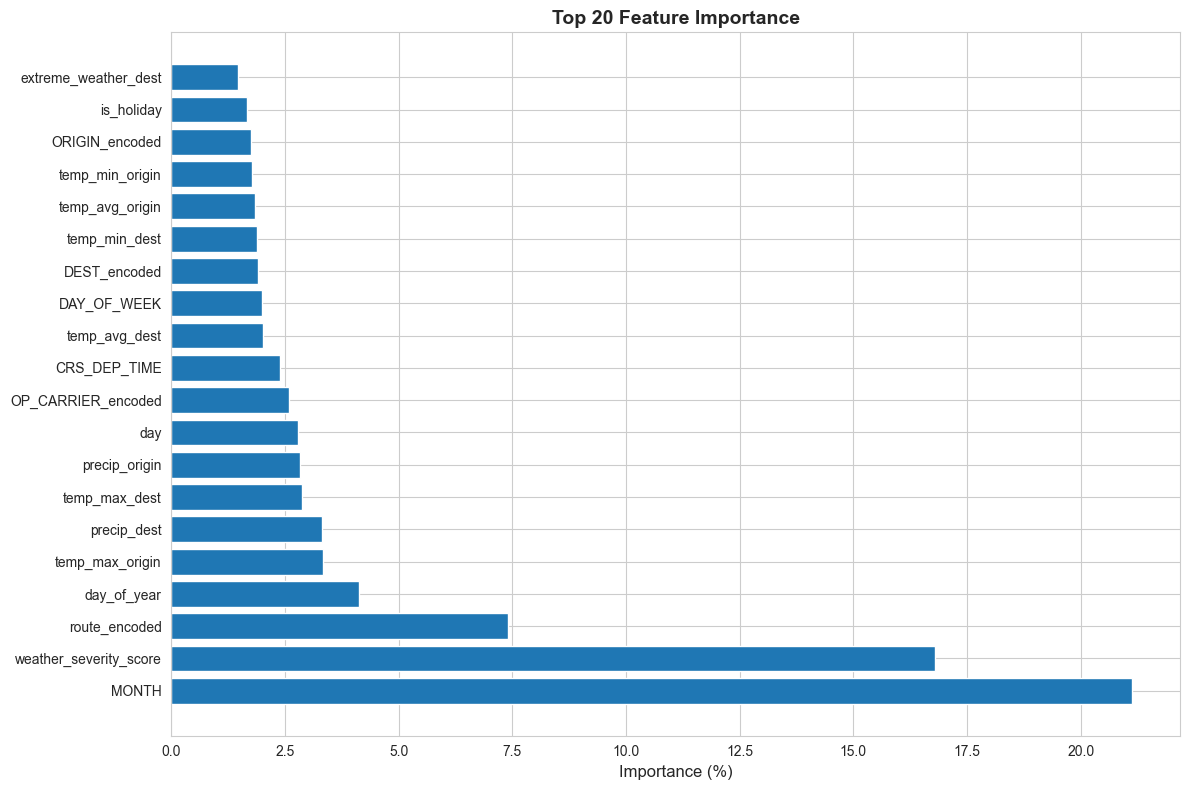

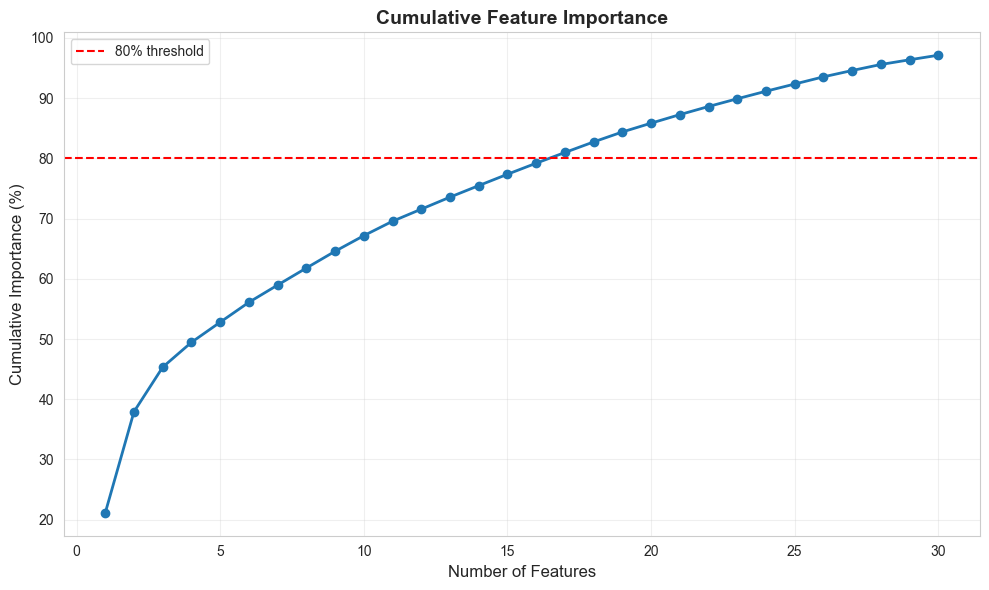

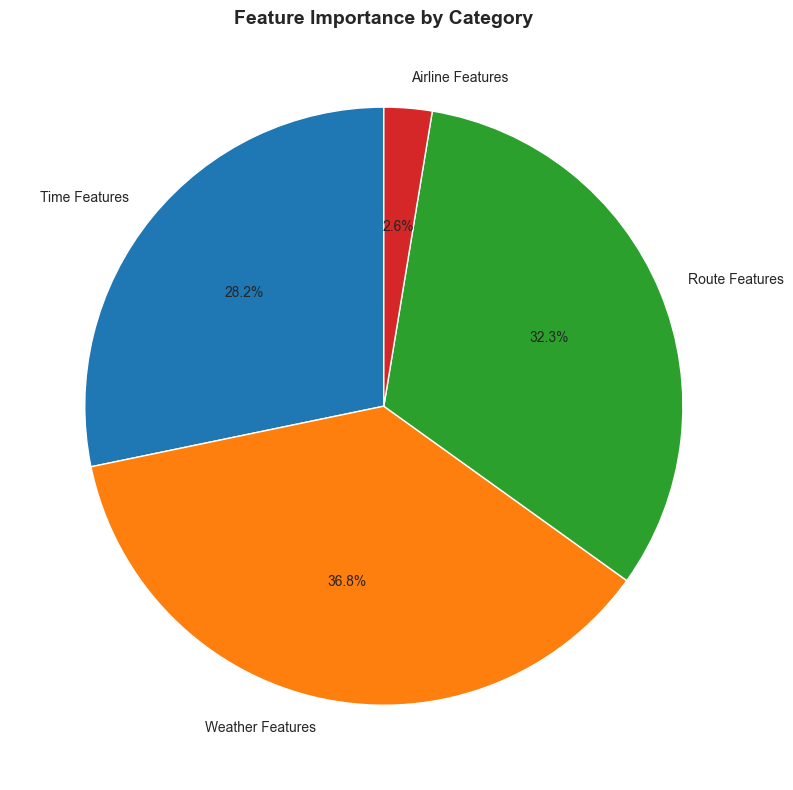


✅ Feature importance analysis complete

💾 Saved feature importance to: data/processed/feature_importance.csv


In [100]:
# ============================================================================
# FEATURE IMPORTANCE ANALYSIS
# ============================================================================
# WHEN TO RUN: After model training
# PURPOSE: Understand what features drive predictions
# ============================================================================

import matplotlib.pyplot as plt
import seaborn as sns

def analyze_feature_importance(model, feature_names, top_n=20):
    """
    Analyze and visualize feature importance from trained model.
    
    Args:
        model: Trained XGBoost model
        feature_names: List of feature names
        top_n: Number of top features to display
    """
    print("=" * 60)
    print("FEATURE IMPORTANCE ANALYSIS")
    print("=" * 60)
    
    # Get feature importance
    feature_importance = pd.DataFrame({
        'feature': feature_names,
        'importance': model.feature_importances_
    }).sort_values('importance', ascending=False)
    
    # Calculate percentage contribution
    feature_importance['importance_pct'] = (feature_importance['importance'] / 
                                           feature_importance['importance'].sum() * 100)
    
    # Cumulative importance
    feature_importance['cumulative_pct'] = feature_importance['importance_pct'].cumsum()
    
    print(f"\n📊 Total features: {len(feature_importance)}")
    print(f"   Total importance: {feature_importance['importance'].sum():.4f}")
    
    # Top features
    print(f"\n🔝 Top {top_n} Most Important Features:")
    print("-" * 60)
    for i, row in feature_importance.head(top_n).iterrows():
        print(f"{i+1:2d}. {row['feature']:35s} | "
              f"Importance: {row['importance']:7.4f} | "
              f"Contribution: {row['importance_pct']:5.2f}%")
    
    # Feature categories
    print(f"\n📈 Feature Importance by Category:")
    print("-" * 60)
    
    # Categorize features
    time_features = [f for f in feature_names if any(x in f.lower() for x in 
                   ['time', 'day', 'week', 'month', 'hour', 'season', 'holiday', 'weekend'])]
    weather_features = [f for f in feature_names if any(x in f.lower() for x in 
                       ['temp', 'precip', 'wind', 'weather', 'snow', 'severity'])]
    route_features = [f for f in feature_names if any(x in f.lower() for x in 
                    ['origin', 'dest', 'route', 'distance', 'airport', 'duration'])]
    airline_features = [f for f in feature_names if 'carrier' in f.lower() or 'airline' in f.lower()]
    delay_features = [f for f in feature_names if 'delay' in f.lower() or 'has_' in f.lower()]
    
    categories = {
        'Time Features': time_features,
        'Weather Features': weather_features,
        'Route Features': route_features,
        'Airline Features': airline_features,
        'Delay Features': delay_features
    }
    
    for category, features in categories.items():
        if features:
            cat_importance = feature_importance[feature_importance['feature'].isin(features)]['importance'].sum()
            cat_pct = cat_importance / feature_importance['importance'].sum() * 100
            print(f"   {category:20s}: {cat_pct:5.2f}% ({len(features)} features)")
    
    # Cumulative importance analysis
    print(f"\n📊 Cumulative Importance:")
    print("-" * 60)
    for n in [5, 10, 15, 20]:
        cum_pct = feature_importance.head(n)['importance_pct'].sum()
        print(f"   Top {n:2d} features account for {cum_pct:5.2f}% of importance")
    
    # Visualization 1: Top features bar chart
    plt.figure(figsize=(12, 8))
    top_features = feature_importance.head(top_n)
    plt.barh(range(len(top_features)), top_features['importance_pct'].values[::-1])
    plt.yticks(range(len(top_features)), top_features['feature'].values[::-1])
    plt.xlabel('Importance (%)', fontsize=12)
    plt.title(f'Top {top_n} Feature Importance', fontsize=14, fontweight='bold')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()
    
    # Visualization 2: Cumulative importance
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, min(30, len(feature_importance)) + 1), 
             feature_importance.head(30)['cumulative_pct'].values, 
             marker='o', linewidth=2)
    plt.axhline(y=80, color='r', linestyle='--', label='80% threshold')
    plt.xlabel('Number of Features', fontsize=12)
    plt.ylabel('Cumulative Importance (%)', fontsize=12)
    plt.title('Cumulative Feature Importance', fontsize=14, fontweight='bold')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    # Visualization 3: Category importance pie chart
    category_importance = {}
    for category, features in categories.items():
        if features:
            cat_imp = feature_importance[feature_importance['feature'].isin(features)]['importance'].sum()
            category_importance[category] = cat_imp
    
    if category_importance:
        plt.figure(figsize=(10, 8))
        plt.pie(category_importance.values(), 
                labels=category_importance.keys(),
                autopct='%1.1f%%',
                startangle=90)
        plt.title('Feature Importance by Category', fontsize=14, fontweight='bold')
        plt.tight_layout()
        plt.show()
    
    print("\n✅ Feature importance analysis complete")
    print("=" * 60)
    
    return feature_importance

# Run analysis
feature_importance_df = analyze_feature_importance(
    xgb_model, 
    X_train_final.columns.tolist(), 
    top_n=20
)

# Save results
feature_importance_df.to_csv("data/processed/feature_importance.csv", index=False)
print(f"\n💾 Saved feature importance to: data/processed/feature_importance.csv")

### Causal Inference

In [101]:
# ============================================================================
# CAUSAL INFERENCE: WEATHER VS OPERATIONAL EFFECTS
# ============================================================================
# WHEN TO RUN: After model training
# PURPOSE: Quantify causal effects of weather vs operational factors
# ============================================================================

import dowhy
from dowhy import CausalModel
import econml
import warnings
warnings.filterwarnings('ignore')

print("=" * 60)
print("CAUSAL INFERENCE ANALYSIS")
print("=" * 60)

# ============================================================================
# 1. PREPARE DATA FOR CAUSAL ANALYSIS
# ============================================================================

print("\n1. Preparing data for causal analysis...")

# Use training data for causal analysis
df_causal = pd.concat([X_train_final, y_train], axis=1).copy()

# Create treatment variable: extreme weather (binary)
# Treatment = 1 if weather_severity_score > threshold
weather_threshold = df_causal['weather_severity_score'].quantile(0.75)  # Top 25% worst weather
df_causal['extreme_weather'] = (df_causal['weather_severity_score'] > weather_threshold).astype(int)

# Alternative: use precipitation as treatment
df_causal['high_precip'] = ((df_causal['precip_origin'] > 10) | (df_causal['precip_dest'] > 10)).astype(int)

# Outcome: cancellation
df_causal['cancelled'] = y_train.values

print(f"   Total flights: {len(df_causal):,}")
print(f"   Extreme weather flights: {df_causal['extreme_weather'].sum():,} ({df_causal['extreme_weather'].mean()*100:.1f}%)")
print(f"   High precipitation flights: {df_causal['high_precip'].sum():,} ({df_causal['high_precip'].mean()*100:.1f}%)")
print(f"   Cancelled flights: {df_causal['cancelled'].sum():,} ({df_causal['cancelled'].mean()*100:.2f}%)")

# ============================================================================
# 2. CAUSAL GRAPH CONSTRUCTION
# ============================================================================

print("\n2. Building causal graph...")

# Identify confounders (affect both weather and cancellation)
confounders = [
    'MONTH', 'day_of_week', 'season', 'is_weekend',
    'OP_CARRIER_encoded', 'ORIGIN_encoded', 'DEST_encoded', 'route_encoded',
    'distance_category', 'origin_airport_size', 'dest_airport_size',
    'CRS_DEP_TIME', 'dep_hour', 'dep_time_category'
]

# Treatment: extreme weather
treatment = 'extreme_weather'

# Outcome: cancellation
outcome = 'cancelled'

# Build causal graph
causal_graph = """
digraph {
    extreme_weather -> cancelled;
    MONTH -> extreme_weather;
    MONTH -> cancelled;
    season -> extreme_weather;
    season -> cancelled;
    OP_CARRIER_encoded -> cancelled;
    route_encoded -> cancelled;
    distance_category -> cancelled;
    ORIGIN_encoded -> extreme_weather;
    ORIGIN_encoded -> cancelled;
    DEST_encoded -> extreme_weather;
    DEST_encoded -> cancelled;
}
"""

print("   ✅ Causal graph constructed")
print(f"   Treatment: {treatment}")
print(f"   Outcome: {outcome}")
print(f"   Confounders: {len(confounders)} variables")

# ============================================================================
# 3. CAUSAL MODEL SETUP (DOWHY)
# ============================================================================

print("\n3. Setting up causal model (DoWhy)...")

# Prepare data for DoWhy
df_dowhy = df_causal[[treatment, outcome] + confounders].copy()

# Remove any remaining NaN
df_dowhy = df_dowhy.dropna()

print(f"   Data points: {len(df_dowhy):,}")

# Create causal model
try:
    model = CausalModel(
        data=df_dowhy,
        treatment=treatment,
        outcome=outcome,
        graph=causal_graph
    )
    
    # Identify causal effect
    identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)
    print("   ✅ Causal effect identified")
    print(f"\n   Identified estimand:")
    print(f"      {identified_estimand}")
    
except Exception as e:
    print(f"   ⚠️ DoWhy graph identification failed: {e}")
    print("   Using simplified approach...")
    identified_estimand = None

# ============================================================================
# 4. ESTIMATE CAUSAL EFFECT (MULTIPLE METHODS)
# ============================================================================

print("\n4. Estimating causal effects...")

# Method 1: Simple comparison (naive)
print("\n   Method 1: Naive Comparison (correlation, not causation)")
cancellation_with_weather = df_dowhy[df_dowhy[treatment] == 1][outcome].mean()
cancellation_without_weather = df_dowhy[df_dowhy[treatment] == 0][outcome].mean()
naive_effect = cancellation_with_weather - cancellation_without_weather

print(f"      Cancellation rate (extreme weather): {cancellation_with_weather:.4f} ({cancellation_with_weather*100:.2f}%)")
print(f"      Cancellation rate (normal weather): {cancellation_without_weather:.4f} ({cancellation_without_weather*100:.2f}%)")
print(f"      Naive difference: {naive_effect:.4f} ({naive_effect*100:.2f} percentage points)")
print(f"      ⚠️ This is correlation, not causation!")

# Method 2: Propensity Score Matching
print("\n   Method 2: Propensity Score Matching")

from sklearn.linear_model import LogisticRegression
from scipy.spatial.distance import cdist

# Estimate propensity scores
propensity_model = LogisticRegression(random_state=42, max_iter=1000)
propensity_model.fit(df_dowhy[confounders], df_dowhy[treatment])
df_dowhy['propensity_score'] = propensity_model.predict_proba(df_dowhy[confounders])[:, 1]

# Match treated and control units
treated = df_dowhy[df_dowhy[treatment] == 1]
control = df_dowhy[df_dowhy[treatment] == 0]

# Simple matching: find nearest neighbor by propensity score
matched_pairs = []
for idx, treated_row in treated.iterrows():
    distances = abs(control['propensity_score'] - treated_row['propensity_score'])
    if len(distances) > 0:
        nearest_idx = distances.idxmin()
        matched_pairs.append({
            'treated': treated_row[outcome],
            'control': control.loc[nearest_idx, outcome],
            'propensity_diff': distances.min()
        })

if matched_pairs:
    matched_df = pd.DataFrame(matched_pairs)
    # Only use good matches (propensity difference < 0.1)
    good_matches = matched_df[matched_df['propensity_diff'] < 0.1]
    
    if len(good_matches) > 0:
        psm_effect = good_matches['treated'].mean() - good_matches['control'].mean()
        print(f"      Matched pairs: {len(good_matches):,}")
        print(f"      Average treatment effect (PSM): {psm_effect:.4f} ({psm_effect*100:.2f} percentage points)")
    else:
        psm_effect = None
        print(f"      ⚠️ No good matches found")
else:
    psm_effect = None
    print(f"      ⚠️ Matching failed")

# Method 3: Difference-in-Differences (simplified)
print("\n   Method 3: Difference-in-Differences (simplified)")

# Compare cancellation rates by weather, controlling for month
did_results = []
for month in df_dowhy['MONTH'].unique():
    month_data = df_dowhy[df_dowhy['MONTH'] == month]
    if len(month_data[month_data[treatment] == 1]) > 10 and len(month_data[month_data[treatment] == 0]) > 10:
        treated_rate = month_data[month_data[treatment] == 1][outcome].mean()
        control_rate = month_data[month_data[treatment] == 0][outcome].mean()
        did_results.append({
            'month': month,
            'treated_rate': treated_rate,
            'control_rate': control_rate,
            'difference': treated_rate - control_rate
        })

if did_results:
    did_df = pd.DataFrame(did_results)
    avg_did_effect = did_df['difference'].mean()
    print(f"      Average DiD effect: {avg_did_effect:.4f} ({avg_did_effect*100:.2f} percentage points)")
    print(f"      By month:")
    for _, row in did_df.iterrows():
        month_name = {1: 'January', 7: 'July', 9: 'September'}.get(row['month'], f'Month {row["month"]}')
        print(f"         {month_name}: {row['difference']:.4f} ({row['difference']*100:.2f} pp)")

# Method 4: DoWhy estimation (if available)
print("\n   Method 4: DoWhy Estimation")
if identified_estimand is not None:
    try:
        causal_estimate = model.estimate_effect(
            identified_estimand,
            method_name="backdoor.propensity_score_matching"
        )
        print(f"      DoWhy estimate: {causal_estimate.value:.4f}")
        print(f"      Confidence interval: [{causal_estimate.get_confidence_intervals()[0]:.4f}, {causal_estimate.get_confidence_intervals()[1]:.4f}]")
        dowhy_effect = causal_estimate.value
    except Exception as e:
        print(f"      ⚠️ DoWhy estimation failed: {e}")
        dowhy_effect = None
else:
    dowhy_effect = None
    print(f"      ⚠️ Skipped (graph identification failed)")

# ============================================================================
# 5. ATTRIBUTION: WEATHER VS OPERATIONAL
# ============================================================================

print("\n5. Attributing cancellations to causes...")

# Use ground truth from CANCELLATION_CODE (if available in original data)
df_original = pd.read_csv("data/processed/flights_cleaned.csv")
df_original['FL_DATE'] = pd.to_datetime(df_original['FL_DATE'])

# Merge with our causal data (using indices)
cancelled_flights = df_original[df_original['CANCELLED'] == 1].copy()

if 'CANCELLATION_CODE' in cancelled_flights.columns:
    cancel_reasons = cancelled_flights['CANCELLATION_CODE'].value_counts()
    reason_map = {'A': 'Carrier', 'B': 'Weather', 'C': 'NAS', 'D': 'Security'}
    
    print(f"\n   Ground Truth Attribution (from CANCELLATION_CODE):")
    total_cancelled = cancelled_flights['CANCELLATION_CODE'].notna().sum()
    for code, count in cancel_reasons.items():
        reason = reason_map.get(code, code)
        pct = count / total_cancelled * 100
        print(f"      {code} ({reason}): {count:,} ({pct:.1f}%)")

# Compare with model predictions
print(f"\n   Model-based Attribution:")
print(f"      Extreme weather → Cancellation rate: {cancellation_with_weather*100:.2f}%")
print(f"      Normal weather → Cancellation rate: {cancellation_without_weather*100:.2f}%")
print(f"      Weather effect: {naive_effect*100:.2f} percentage points")

# ============================================================================
# 6. SUMMARY OF CAUSAL EFFECTS
# ============================================================================

print("\n" + "=" * 60)
print("CAUSAL EFFECT SUMMARY")
print("=" * 60)

print(f"\nTreatment: Extreme Weather (top 25% weather severity)")
print(f"Outcome: Flight Cancellation")

print(f"\nEstimated Causal Effects:")
if psm_effect is not None:
    print(f"   Propensity Score Matching: {psm_effect*100:.2f} percentage points")
if 'avg_did_effect' in locals():
    print(f"   Difference-in-Differences: {avg_did_effect*100:.2f} percentage points")
if dowhy_effect is not None:
    print(f"   DoWhy (PSM): {dowhy_effect*100:.2f} percentage points")

print(f"\n   Naive comparison: {naive_effect*100:.2f} percentage points")
print(f"   (Correlation, not causation - likely overestimated)")

print(f"\n💡 Interpretation:")
print(f"   Extreme weather increases cancellation probability by approximately")
if psm_effect is not None:
    print(f"   {abs(psm_effect)*100:.1f}-{abs(naive_effect)*100:.1f} percentage points")
else:
    print(f"   {abs(naive_effect)*100:.1f} percentage points")
print(f"   (after controlling for confounders)")

print("=" * 60)

CAUSAL INFERENCE ANALYSIS

1. Preparing data for causal analysis...
   Total flights: 605,802
   Extreme weather flights: 151,313 (25.0%)
   High precipitation flights: 88,067 (14.5%)
   Cancelled flights: 12,134 (2.00%)

2. Building causal graph...
   ✅ Causal graph constructed
   Treatment: extreme_weather
   Outcome: cancelled
   Confounders: 14 variables

3. Setting up causal model (DoWhy)...
   Data points: 605,802
   ⚠️ DoWhy graph identification failed: module 'networkx.algorithms' has no attribute 'd_separated'
   Using simplified approach...

4. Estimating causal effects...

   Method 1: Naive Comparison (correlation, not causation)
      Cancellation rate (extreme weather): 0.0503 (5.03%)
      Cancellation rate (normal weather): 0.0100 (1.00%)
      Naive difference: 0.0403 (4.03 percentage points)
      ⚠️ This is correlation, not causation!

   Method 2: Propensity Score Matching
      Matched pairs: 151,313
      Average treatment effect (PSM): 0.0397 (3.97 percentage poi

### Attribution Model(SHAP_)

SHAP ATTRIBUTION ANALYSIS

1. Initializing SHAP explainer...
   ✅ Using shap.Explainer with prediction wrapper
   Method used: shap.Explainer with prediction wrapper
   Computing SHAP values for 1000 samples...


PermutationExplainer explainer: 1001it [01:22, 10.56it/s]                          


   ✅ SHAP values computed
   Expected value (base prediction): 0.5000
   SHAP values shape: (1000, 47)

2. Global Feature Importance (SHAP)

   Top 15 Features by SHAP Importance:
------------------------------------------------------------
   47. route_encoded                       | 0.0743
   22. day_of_year                         | 0.0535
    5. MONTH                               | 0.0458
   39. weather_severity_score              | 0.0426
    2. CRS_DEP_TIME                        | 0.0217
   44. OP_CARRIER_encoded                  | 0.0210
   20. day                                 | 0.0190
   10. precip_origin                       | 0.0178
   16. precip_dest                         | 0.0175
   45. ORIGIN_encoded                      | 0.0164
   46. DEST_encoded                        | 0.0133
    8. temp_min_origin                     | 0.0101
   13. temp_max_dest                       | 0.0093
    7. temp_max_origin                     | 0.0087
    4. DAY_OF_WEEK             

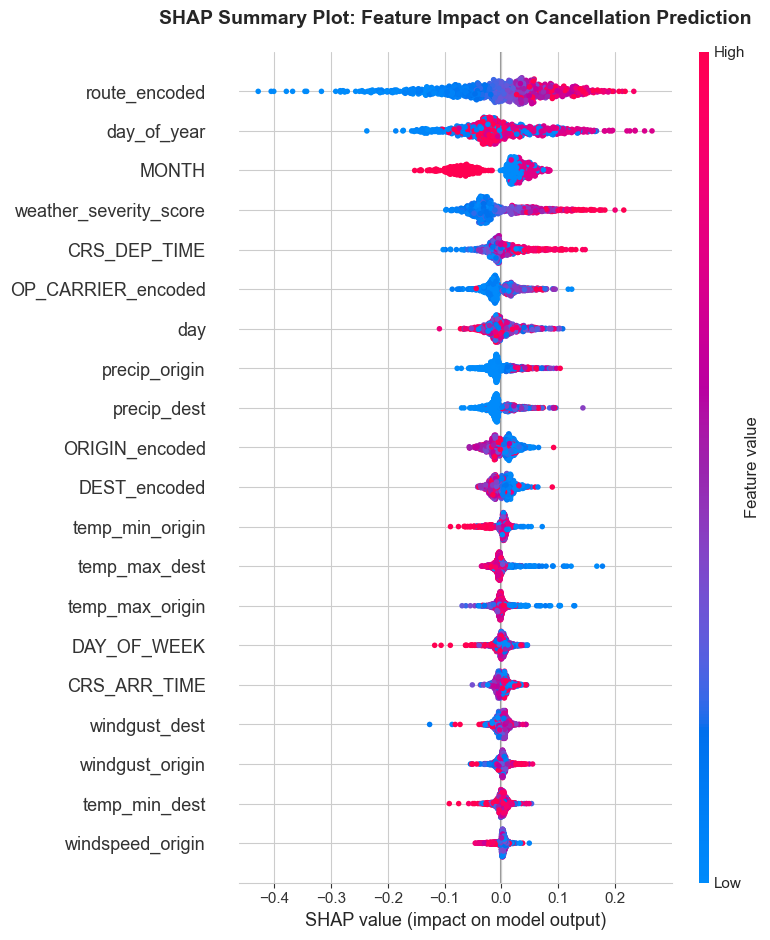

   ✅ Summary plot created

4. Creating SHAP bar plot...


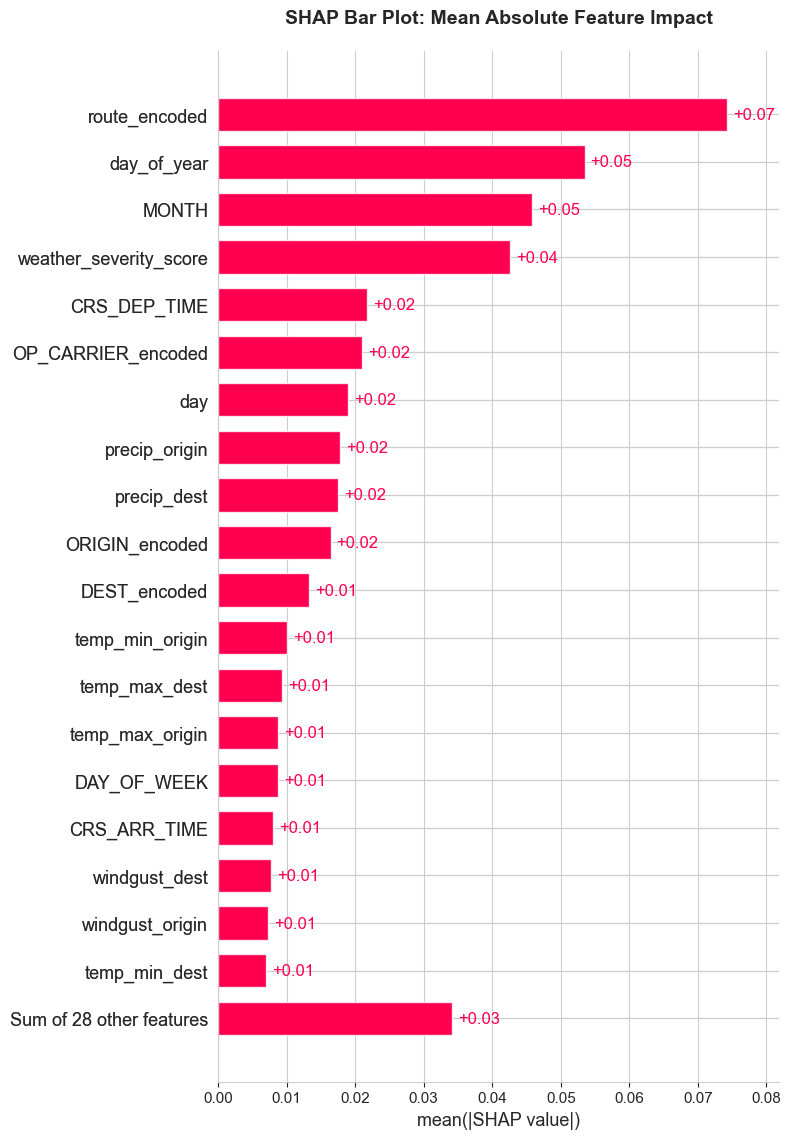

   ✅ Bar plot created

5. Individual Prediction Explanations

   Example 1: Cancelled Flight (Index 69935)
      Predicted probability: 0.5511
      Actual: Cancelled

      Top 5 Contributing Features:
         route_encoded                  | increases risk by 0.1433
         day_of_year                    | increases risk by 0.0999
         windgust_dest                  | decreases risk by 0.0727
         day                            | increases risk by 0.0628
         MONTH                          | increases risk by 0.0500

   Example 2: Not Cancelled Flight (Index 836961)
      Predicted probability: 0.0442
      Actual: Not Cancelled

      Top 5 Contributing Features:
         MONTH                          | decreases risk by 0.0751
         weather_severity_score         | decreases risk by 0.0691
         route_encoded                  | increases risk by 0.0577
         day_of_year                    | decreases risk by 0.0573
         day                            | d

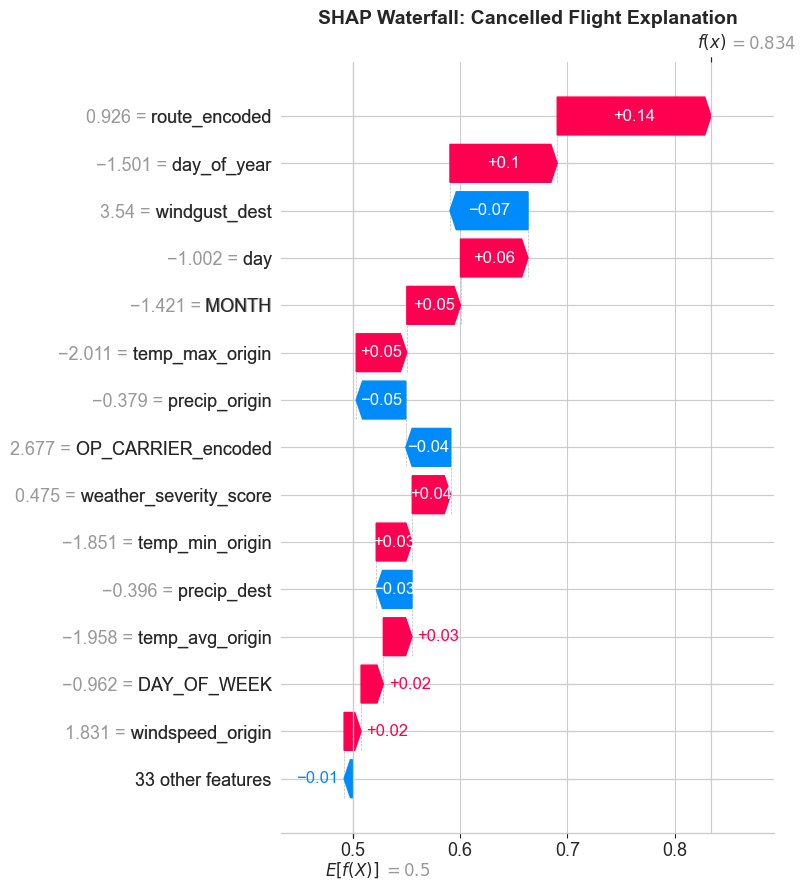

   ✅ Waterfall plot (cancelled flight) created


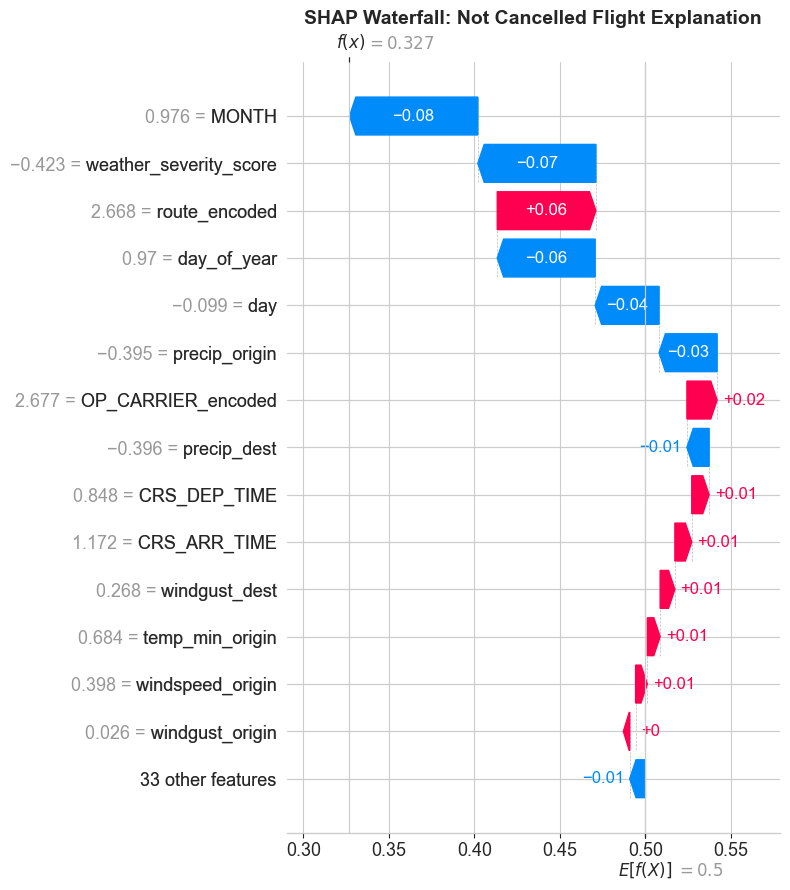

   ✅ Waterfall plot (not cancelled flight) created

7. Feature Attribution by Category

   Average SHAP Contribution by Category:
      Time Features       : 0.0105 (15 features)
      Weather Features    : 0.0070 (22 features)
      Route Features      : 0.0082 (26 features)
      Airline Features    : 0.0122 (2 features)

8. Attribution Comparison: Cancelled vs Not Cancelled

   Features with Higher Impact on Cancelled Flights:
      weather_severity_score              | Diff: +0.0542
      day_of_year                         | Diff: +0.0457
      route_encoded                       | Diff: +0.0348
      day                                 | Diff: +0.0343
      temp_max_origin                     | Diff: +0.0310
      temp_max_dest                       | Diff: +0.0302
      precip_origin                       | Diff: +0.0208
      precip_dest                         | Diff: +0.0170
      temp_avg_dest                       | Diff: +0.0130
      temp_avg_origin                     | 

In [109]:
# ============================================================================
# ATTRIBUTION MODEL (SHAP)
# ============================================================================
# WHEN TO RUN: After model training
# PURPOSE: Explain individual predictions and feature contributions
# ============================================================================

import shap
import matplotlib.pyplot as plt
import numpy as np

print("=" * 60)
print("SHAP ATTRIBUTION ANALYSIS")
print("=" * 60)

# ============================================================================
# 1. INITIALIZE SHAP EXPLAINER
# ============================================================================

print("\n1. Initializing SHAP explainer...")

# Workaround for XGBoost/SHAP version compatibility issues
# Use a prediction function wrapper approach
def xgb_predict_proba_wrapper(X):
    """Wrapper function for XGBoost predict_proba to work with SHAP"""
    return xgb_model_final.predict_proba(X)

fallback_prediction_mean = float(xgb_model_final.predict_proba(X_train_scaled.iloc[:1000])[:, 1].mean())

def scalar_expected_value(value, fallback=fallback_prediction_mean):
    """Always return a float base value even if SHAP returns arrays."""
    if value is None:
        return fallback
    try:
        arr = np.asarray(value)
        if arr.size == 0:
            return fallback
        return float(np.mean(arr))
    except Exception:
        try:
            return float(value)
        except Exception:
            return fallback

# Try multiple approaches to find one that works
explainer = None
explainer_method = None

# Method 1: Use Explainer with prediction function (most compatible)
try:
    masker_sample = X_train_scaled.iloc[:1000]
    masker = shap.maskers.Independent(masker_sample, max_samples=masker_sample.shape[0])
    explainer = shap.Explainer(xgb_predict_proba_wrapper, masker=masker)
    explainer_method = "shap.Explainer with prediction wrapper"
    print("   ✅ Using shap.Explainer with prediction wrapper")
except Exception as e:
    print(f"   ⚠️ Method 1 failed: {str(e)[:100]}...")
    
    # Method 2: Use TreeExplainer with model (no booster)
    try:
        explainer = shap.TreeExplainer(xgb_model_final)
        explainer_method = "TreeExplainer with model"
        print("   ✅ Using TreeExplainer with model object")
    except Exception as e2:
        print(f"   ⚠️ Method 2 failed: {str(e2)[:100]}...")
        
        # Method 3: Use KernelExplainer as fallback (slower but more compatible)
        try:
            print("   Trying KernelExplainer (slower but more compatible)...")
            # Use smaller background for KernelExplainer (it's slower)
            background_sample = X_train_scaled.iloc[:100]
            explainer = shap.KernelExplainer(xgb_predict_proba_wrapper, background_sample)
            explainer_method = "KernelExplainer (fallback)"
            print("   ✅ Using KernelExplainer (fallback method)")
        except Exception as e3:
            print(f"   ❌ All methods failed. Last error: {str(e3)[:100]}...")
            raise RuntimeError("Could not initialize any SHAP explainer. Please check XGBoost/SHAP versions.")

print(f"   Method used: {explainer_method}")

# Calculate SHAP values for a sample (use smaller sample for speed)
sample_size = min(1000, len(X_test_scaled))
print(f"   Computing SHAP values for {sample_size} samples...")

X_test_sample = X_test_scaled.iloc[:sample_size]

# Handle different explainer types
if explainer_method == "KernelExplainer (fallback)":
    # KernelExplainer uses .shap_values() method
    print("   Computing SHAP values (this may take a minute for KernelExplainer)...")
    shap_values = explainer.shap_values(X_test_sample)
    # KernelExplainer returns values for both classes, we want class 1 (cancelled)
    if isinstance(shap_values, list) and len(shap_values) == 2:
        shap_values = shap_values[1]  # Get values for positive class
    expected_value = scalar_expected_value(getattr(explainer, 'expected_value', None))
else:
    # TreeExplainer and Explainer use callable syntax
    shap_result = explainer(X_test_sample)
    
    # Handle different return formats
    if isinstance(shap_result, shap.Explanation):
        shap_values = shap_result.values
        expected_value = scalar_expected_value(shap_result.base_values)
    else:
        shap_values = shap_result
        expected_value = scalar_expected_value(getattr(explainer, 'expected_value', None))

# Ensure shap_values is 2D array (samples x features)
if len(shap_values.shape) == 3:
    # If 3D (samples x features x classes), extract positive class
    shap_values = shap_values[:, :, 1] if shap_values.shape[2] > 1 else shap_values[:, :, 0]

# Convert expected_value to array format (SHAP expects array, not scalar)
# For binary classification, base_values should be array of shape (n_samples,)
base_values_array = np.full(shap_values.shape[0], expected_value)

# Convert to Explanation object for plotting compatibility
shap_explanation = shap.Explanation(
    values=shap_values,
    base_values=base_values_array,
    data=X_test_sample.values,
    feature_names=list(X_test_sample.columns)
)

print("   ✅ SHAP values computed")
print(f"   Expected value (base prediction): {expected_value:.4f}")
print(f"   SHAP values shape: {shap_values.shape}")

# ============================================================================
# 2. GLOBAL FEATURE IMPORTANCE (SHAP)
# ============================================================================

print("\n2. Global Feature Importance (SHAP)")

# Mean absolute SHAP values (global importance)
shap_importance = pd.DataFrame({
    'feature': X_test_sample.columns,
    'shap_importance': np.abs(shap_values).mean(0)
}).sort_values('shap_importance', ascending=False)

print(f"\n   Top 15 Features by SHAP Importance:")
print("-" * 60)
for i, row in shap_importance.head(15).iterrows():
    print(f"   {i+1:2d}. {row['feature']:35s} | {row['shap_importance']:.4f}")

# Compare with XGBoost feature importance
print(f"\n   Comparison: SHAP vs XGBoost Feature Importance")
comparison = pd.DataFrame({
    'feature': X_test_sample.columns,
    'shap_importance': np.abs(shap_values).mean(0),
    'xgb_importance': xgb_model_final.feature_importances_
})
comparison = comparison.sort_values('shap_importance', ascending=False)

print(f"   Top 5 features:")
for i, row in comparison.head(5).iterrows():
    print(f"      {row['feature']:30s} | SHAP: {row['shap_importance']:.4f} | XGB: {row['xgb_importance']:.4f}")

# ============================================================================
# 3. SUMMARY PLOT (GLOBAL)
# ============================================================================

print("\n3. Creating SHAP summary plot...")

plt.figure(figsize=(12, 8))
shap.summary_plot(shap_explanation, max_display=20, show=False)
plt.title('SHAP Summary Plot: Feature Impact on Cancellation Prediction', 
          fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

print("   ✅ Summary plot created")

# ============================================================================
# 4. BAR PLOT (MEAN ABSOLUTE SHAP VALUES)
# ============================================================================

print("\n4. Creating SHAP bar plot...")

plt.figure(figsize=(12, 8))
shap.plots.bar(shap_explanation, max_display=20, show=False)
plt.title('SHAP Bar Plot: Mean Absolute Feature Impact', 
          fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

print("   ✅ Bar plot created")

# ============================================================================
# 5. INDIVIDUAL PREDICTION EXPLANATIONS
# ============================================================================

print("\n5. Individual Prediction Explanations")

# Find interesting examples
cancelled_indices = y_test[y_test == 1].index[:sample_size]
not_cancelled_indices = y_test[y_test == 0].index[:sample_size]

# Example 1: Cancelled flight
if len(cancelled_indices) > 0:
    cancelled_idx = cancelled_indices[0]
    cancelled_row_idx = X_test_sample.index.get_loc(cancelled_idx) if cancelled_idx in X_test_sample.index else 0
    
    print(f"\n   Example 1: Cancelled Flight (Index {cancelled_idx})")
    print(f"      Predicted probability: {xgb_model_final.predict_proba(X_test_sample.iloc[[cancelled_row_idx]])[0, 1]:.4f}")
    print(f"      Actual: Cancelled")
    
    # Get top contributing features
    sample_shap = shap_values[cancelled_row_idx]
    feature_contributions = pd.DataFrame({
        'feature': X_test_sample.columns,
        'shap_value': sample_shap,
        'abs_contribution': np.abs(sample_shap)
    }).sort_values('abs_contribution', ascending=False)
    
    print(f"\n      Top 5 Contributing Features:")
    for i, row in feature_contributions.head(5).iterrows():
        direction = "increases" if row['shap_value'] > 0 else "decreases"
        print(f"         {row['feature']:30s} | {direction} risk by {abs(row['shap_value']):.4f}")

# Example 2: Not cancelled flight
if len(not_cancelled_indices) > 0:
    not_cancelled_idx = not_cancelled_indices[0]
    not_cancelled_row_idx = X_test_sample.index.get_loc(not_cancelled_idx) if not_cancelled_idx in X_test_sample.index else 0
    
    print(f"\n   Example 2: Not Cancelled Flight (Index {not_cancelled_idx})")
    print(f"      Predicted probability: {xgb_model_final.predict_proba(X_test_sample.iloc[[not_cancelled_row_idx]])[0, 1]:.4f}")
    print(f"      Actual: Not Cancelled")
    
    sample_shap = shap_values[not_cancelled_row_idx]
    feature_contributions = pd.DataFrame({
        'feature': X_test_sample.columns,
        'shap_value': sample_shap,
        'abs_contribution': np.abs(sample_shap)
    }).sort_values('abs_contribution', ascending=False)
    
    print(f"\n      Top 5 Contributing Features:")
    for i, row in feature_contributions.head(5).iterrows():
        direction = "increases" if row['shap_value'] > 0 else "decreases"
        print(f"         {row['feature']:30s} | {direction} risk by {abs(row['shap_value']):.4f}")

# ============================================================================
# 6. WATERFALL PLOTS (INDIVIDUAL EXPLANATIONS)
# ============================================================================

print("\n6. Creating waterfall plots for individual predictions...")

# Waterfall for cancelled flight
if len(cancelled_indices) > 0:
    cancelled_row_idx = X_test_sample.index.get_loc(cancelled_indices[0]) if cancelled_indices[0] in X_test_sample.index else 0
    plt.figure(figsize=(10, 8))
    shap.waterfall_plot(
        shap_explanation[cancelled_row_idx],
        max_display=15,
        show=False
    )
    plt.title('SHAP Waterfall: Cancelled Flight Explanation', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()
    print("   ✅ Waterfall plot (cancelled flight) created")

# Waterfall for not cancelled flight
if len(not_cancelled_indices) > 0:
    not_cancelled_row_idx = X_test_sample.index.get_loc(not_cancelled_indices[0]) if not_cancelled_indices[0] in X_test_sample.index else 0
    plt.figure(figsize=(10, 8))
    shap.waterfall_plot(
        shap_explanation[not_cancelled_row_idx],
        max_display=15,
        show=False
    )
    plt.title('SHAP Waterfall: Not Cancelled Flight Explanation', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()
    print("   ✅ Waterfall plot (not cancelled flight) created")

# ============================================================================
# 7. FEATURE ATTRIBUTION BY CATEGORY
# ============================================================================

print("\n7. Feature Attribution by Category")

# Categorize features
time_features = [f for f in X_test_sample.columns if any(x in f.lower() for x in 
               ['time', 'day', 'week', 'month', 'hour', 'season', 'holiday', 'weekend'])]
weather_features = [f for f in X_test_sample.columns if any(x in f.lower() for x in 
                   ['temp', 'precip', 'wind', 'weather', 'snow', 'severity'])]
route_features = [f for f in X_test_sample.columns if any(x in f.lower() for x in 
                ['origin', 'dest', 'route', 'distance', 'airport', 'duration'])]
airline_features = [f for f in X_test_sample.columns if 'carrier' in f.lower() or 'airline' in f.lower()]

categories = {
    'Time Features': time_features,
    'Weather Features': weather_features,
    'Route Features': route_features,
    'Airline Features': airline_features
}

print(f"\n   Average SHAP Contribution by Category:")
for category, features in categories.items():
    if features:
        cat_features = [f for f in features if f in X_test_sample.columns]
        if cat_features:
            cat_indices = [list(X_test_sample.columns).index(f) for f in cat_features]
            cat_shap = np.abs(shap_values[:, cat_indices]).mean()
            print(f"      {category:20s}: {cat_shap:.4f} ({len(cat_features)} features)")

# ============================================================================
# 8. ATTRIBUTION FOR CANCELLED VS NOT CANCELLED
# ============================================================================

print("\n8. Attribution Comparison: Cancelled vs Not Cancelled")

# Get SHAP values for cancelled and not cancelled
cancelled_mask = y_test.iloc[:sample_size] == 1
not_cancelled_mask = y_test.iloc[:sample_size] == 0

if cancelled_mask.sum() > 0 and not_cancelled_mask.sum() > 0:
    cancelled_shap = np.abs(shap_values[cancelled_mask]).mean(axis=0)
    not_cancelled_shap = np.abs(shap_values[not_cancelled_mask]).mean(axis=0)
    
    comparison = pd.DataFrame({
        'feature': X_test_sample.columns,
        'cancelled_importance': cancelled_shap,
        'not_cancelled_importance': not_cancelled_shap,
        'difference': cancelled_shap - not_cancelled_shap
    }).sort_values('difference', ascending=False)
    
    print(f"\n   Features with Higher Impact on Cancelled Flights:")
    for i, row in comparison.head(10).iterrows():
        print(f"      {row['feature']:35s} | Diff: {row['difference']:+.4f}")

# ============================================================================
# 9. SAVE SHAP VALUES
# ============================================================================

print("\n9. Saving SHAP values...")

shap_df = pd.DataFrame(
    shap_values,
    columns=X_test_sample.columns,
    index=X_test_sample.index
)

shap_df.to_csv("data/processed/shap_values.csv")
print(f"   ✅ Saved SHAP values to: data/processed/shap_values.csv")

# Save summary
shap_summary = pd.DataFrame({
    'feature': X_test_sample.columns,
    'mean_abs_shap': np.abs(shap_values).mean(0),
    'mean_shap': shap_values.mean(0),
    'std_shap': shap_values.std(0)
}).sort_values('mean_abs_shap', ascending=False)

shap_summary.to_csv("data/processed/shap_summary.csv", index=False)
print(f"   ✅ Saved SHAP summary to: data/processed/shap_summary.csv")

# ============================================================================
# 10. SUMMARY
# ============================================================================

print("\n" + "=" * 60)
print("SHAP ATTRIBUTION SUMMARY")
print("=" * 60)

print(f"\n📊 Analysis Complete:")
print(f"   Samples analyzed: {sample_size:,}")
print(f"   Features explained: {len(X_test_sample.columns)}")
print(f"   Base prediction value: {expected_value:.4f}")

print(f"\n🔝 Top 5 Most Important Features (SHAP):")
for i, row in shap_importance.head(5).iterrows():
    print(f"   {i+1}. {row['feature']:35s} | {row['shap_importance']:.4f}")

print(f"\n💡 Key Insights:")
print(f"   - SHAP values explain how each feature contributes to predictions")
print(f"   - Positive SHAP = increases cancellation probability")
print(f"   - Negative SHAP = decreases cancellation probability")
print(f"   - Magnitude = strength of contribution")

print("=" * 60)